# Predviđanje broja gostiju na dnevnoj, tjodnoj i jesečnoj bazi koristeći statistički model ARIMA

**Rezultati** 
- Hotel booking demand dataset
    - Dnevne predikcije
        - Test MAPE City Hotel/%: 0.269380
        - Test MAPE Resort Hotel/%: 0.277995
    - Tjedne predikcije
        - Test MAPE City Hotel/%: 0.610819
        - Test MAPE Resort Hotel/%: 0.189251
    - Mjesečne predikcije
        - Test MAPE City Hotel/%: 0.583682
        - Test MAPE Resort Hotel/%: 0.109033

- Lumen dataset `data/interim/data_wo_cancel.parquet`
- Hotel 0 dataset `data/interim/data_wo_cancel_hotel0.parquet`
- Hotel 1 dataset `data/interim/data_wo_cancel_hotel1.parquet`

| Hotel Type | Data Frequency | Mean Abs Percentage Error (%) | Mean Squared Error | Root Mean Squared Error |
|------------|----------------|-------------------------------|--------------------|-------------------------|
| City       | Daily          | 0.269380                      | 1163.264705        | 34.106667               |
| City       | Weekly         | 0.610819                      | 245406.918078      | 495.385626              |
| City       | Monthly        | 0.583682                      | 4447887.766771     | 2109.001604             |
| Resort     | Daily          | 0.277995                      | 768.783166         | 27.726939               |
| Resort     | Weekly         | 0.189251                      | 13023.739130       | 114.121598              |
| Resort     | Monthly        | 0.109033                      | 97302.000000       | 311.932685              |


# Učitavanje modula

In [102]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import warnings
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, root_mean_squared_error
import os
import random 

for dirname, _, filenames in os.walk('..\\data\\raw'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
warnings.filterwarnings("ignore")

# Učitavanje podataka 

In [65]:
DATA_WO_CANCELLATIONS_PATH = '../data/interim/data_wo_cancel.parquet'
DATA_HOTEL0_PATH = '../data/interim/data_wo_cancel_hotel0.parquet'
DATA_HOTEL1_PATH = '../data/interim/data_wo_cancel_hotel1.parquet'


In [66]:
data = pd.read_parquet(DATA_WO_CANCELLATIONS_PATH)
dataResort = pd.read_parquet(DATA_HOTEL0_PATH)
dataCity = pd.read_parquet(DATA_HOTEL1_PATH)
data.head()

,hotel_id,datum_dolaska,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,gost_id,duljina_boravka,ukupno_gostiju,raspon_dolazak_rezervacija
0,0,2015-07-01,PRT,0,0,100.000000,1077152,0,2.0,161
1,0,2015-07-01,PRT,0,0,100.000000,1017906,0,2.0,21
2,0,2015-07-01,GBR,0,1,64.991345,1039896,1,1.0,49
3,0,2015-07-01,GBR,1,1,74.368897,1008245,1,1.0,397
4,0,2015-07-01,GBR,2,1,130.973278,1093703,2,2.0,360


In [67]:
dataCity.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46047 entries, 28506 to 74552
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   hotel_id                    46047 non-null  int32         
 1   datum_dolaska               46047 non-null  datetime64[ns]
 2   zemlja_gosta                46047 non-null  object        
 3   kanal_prodaje_id            46047 non-null  int32         
 4   tip_sobe_id                 46047 non-null  int32         
 5   cijena_nocenja              46047 non-null  float64       
 6   gost_id                     46047 non-null  int32         
 7   duljina_boravka             46047 non-null  int64         
 8   ukupno_gostiju              46047 non-null  float64       
 9   raspon_dolazak_rezervacija  46047 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(4), int64(2), object(1)
memory usage: 3.2+ MB


In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74553 entries, 0 to 74552
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   hotel_id                    74553 non-null  int32         
 1   datum_dolaska               74553 non-null  datetime64[ns]
 2   zemlja_gosta                74553 non-null  object        
 3   kanal_prodaje_id            74553 non-null  int32         
 4   tip_sobe_id                 74553 non-null  int32         
 5   cijena_nocenja              74553 non-null  float64       
 6   gost_id                     74553 non-null  int32         
 7   duljina_boravka             74553 non-null  int64         
 8   ukupno_gostiju              74553 non-null  float64       
 9   raspon_dolazak_rezervacija  74553 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(4), int64(2), object(1)
memory usage: 4.6+ MB


In [69]:
NaN = data.isna().sum()
NaN

hotel_id                      0
datum_dolaska                 0
zemlja_gosta                  0
kanal_prodaje_id              0
tip_sobe_id                   0
cijena_nocenja                0
gost_id                       0
duljina_boravka               0
ukupno_gostiju                0
raspon_dolazak_rezervacija    0
dtype: int64

### Dodavanje ciljane varijable - ukupan broj gostiju u nekom periodu, na dnevnoj, tjednoj, mjesečnoj i godišnjoj razini

### City Hotel

#### Dnevna razina

In [70]:
NumberOfGuestsDailyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsDailyCity = NumberOfGuestsDailyCity.resample('d').sum().to_frame()
NumberOfGuestsDailyCity.head(5)

,ukupno_gostiju
datum_dolaska,
2015-01-01,10.0
2015-01-02,6.0
2015-01-03,11.0
2015-01-04,8.0
2015-01-05,4.0


#### Tjedna razina

In [71]:
NumberOfGuestsWeeklyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsWeeklyCity = NumberOfGuestsWeeklyCity.resample('W').sum().to_frame()
NumberOfGuestsWeeklyCity.head(5)

,ukupno_gostiju
datum_dolaska,
2015-01-04,35.0
2015-01-11,42.0
2015-01-18,54.0
2015-01-25,48.0
2015-02-01,27.0


#### Mjesečna razina

In [72]:
NumberOfGuestsMonthlyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsMonthlyCity = NumberOfGuestsMonthlyCity .resample('ME').sum().to_frame()
NumberOfGuestsMonthlyCity.head(5)

,ukupno_gostiju
datum_dolaska,
2015-01-31,206.0
2015-02-28,0.0
2015-03-31,0.0
2015-04-30,0.0
2015-05-31,1072.0


#### Godišnja razina

In [73]:
NumberOfGuestsYearlyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsYearlyCity = NumberOfGuestsYearlyCity.resample('y').sum().to_frame()
NumberOfGuestsYearlyCity.head(5)

,ukupno_gostiju
datum_dolaska,
2015-12-31,13723.0
2016-12-31,44405.0
2017-12-31,31254.0


#### Problemi s anomalija kod City Hotela (npr. 0 gostiju u nekim danima)

In [74]:
indexes = NumberOfGuestsDailyCity[NumberOfGuestsDailyCity['ukupno_gostiju'] == 0].index
periods = []
start_date = indexes[0]
for i in range(1, len(indexes)):
    if (indexes[i] - indexes[i-1]).days > 1:
        end_date = indexes[i-1]
        periods.append((start_date, end_date))
        start_date = indexes[i]

periods.append((start_date, indexes[-1]))

for start, end in periods:
    print(f"Periodi gdje je broj gostiju jednak nuli : od {start.date()} do {end.date()}, ukupno {(end - start).days+1} dana")

Periodi gdje je broj gostiju jednak nuli : od 2015-02-01 do 2015-04-30, ukupno 88 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-06-01 do 2015-06-30, ukupno 29 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-05 do 2015-07-06, ukupno 1 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-12 do 2015-07-14, ukupno 2 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-19 do 2015-07-19, ukupno 0 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-21 do 2015-07-21, ukupno 0 dana
Periodi gdje je broj gostiju jednak nuli : od 2017-09-01 do 2017-09-30, ukupno 29 dana


In [75]:
indexes_valid = NumberOfGuestsDailyCity[NumberOfGuestsDailyCity['ukupno_gostiju'] != 0].index
periods_valid = []
start_date = indexes_valid[0]
for i in range(1, len(indexes_valid)):
    if (indexes_valid[i] - indexes_valid[i-1]).days > 1:
        end_date = indexes_valid[i-1]
        periods_valid.append((start_date, end_date))
        start_date = indexes_valid[i]

periods_valid.append((start_date, indexes_valid[-1]))

for start, end in periods_valid:
    print(f"Periodi gdje je broj gostiju različit nuli : od {start.date()} do {end.date()}, ukupno {(end - start).days+1} dana")

Periodi gdje je broj gostiju različit nuli : od 2015-01-01 do 2015-01-31, ukupno 30 dana
Periodi gdje je broj gostiju različit nuli : od 2015-05-01 do 2015-05-31, ukupno 30 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-01 do 2015-07-04, ukupno 3 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-07 do 2015-07-11, ukupno 4 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-15 do 2015-07-18, ukupno 3 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-20 do 2015-07-20, ukupno 0 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-22 do 2017-08-31, ukupno 771 dana
Periodi gdje je broj gostiju različit nuli : od 2017-10-01 do 2017-12-31, ukupno 91 dana


ZAKLJUČAK
- dio podataka gdje je duljina perioda gdje hotel nema gostiju dulja od tjedan dana ima smisla izbaciti, zajedno s podacima koji prethode, ako govorimo o "malom "uzorku "čistih" podataka koji prethode dugim anomalijama
- kako je taj "mali" uzorak podataka koji smijemo izbaciti arbitraran, moguće je modelirati na više načina, s većom/manjom količinom izbacivanja podataka
- manje periode ima smisla modelirati na način da se agregiraju srednje vrijednosti podatka iz susjedstva (npr. tjedan dana prije i poslije) ili interpolirati srednje vrijednosti iz susjedstva
- prethodno može biti primjenjemo na dulje periode, ukoliko je potrebno
- ARIMA model, kao i MAPE metrika, ne reagiraju dobro na anomalije, odnosno MAPE puca (zbog djeljenja s nulom) ako su ciljani podaci nula, odnosno u ovom slučaju za svaki slučaj kada je broj ukupnih gosti na bilo kojoj vremenskoj bazi jednak nuli


In [1]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsDailyCity['ukupno_gostiju'], marker='.', label='Broj gostiju')
plt.plot(NumberOfGuestsDailyCity.loc[indexes, 'ukupno_gostiju'], 'o', color='red', label='Problematične vrijednsosti')

plt.title('Broj gostiju City Hotel an dnevnoj razini')
plt.xlabel('Dan dolaska')
plt.ylabel('Broj gostiju na dnevnoj razini')

plt.legend()
plt.show()

NameError: name 'plt' is not defined

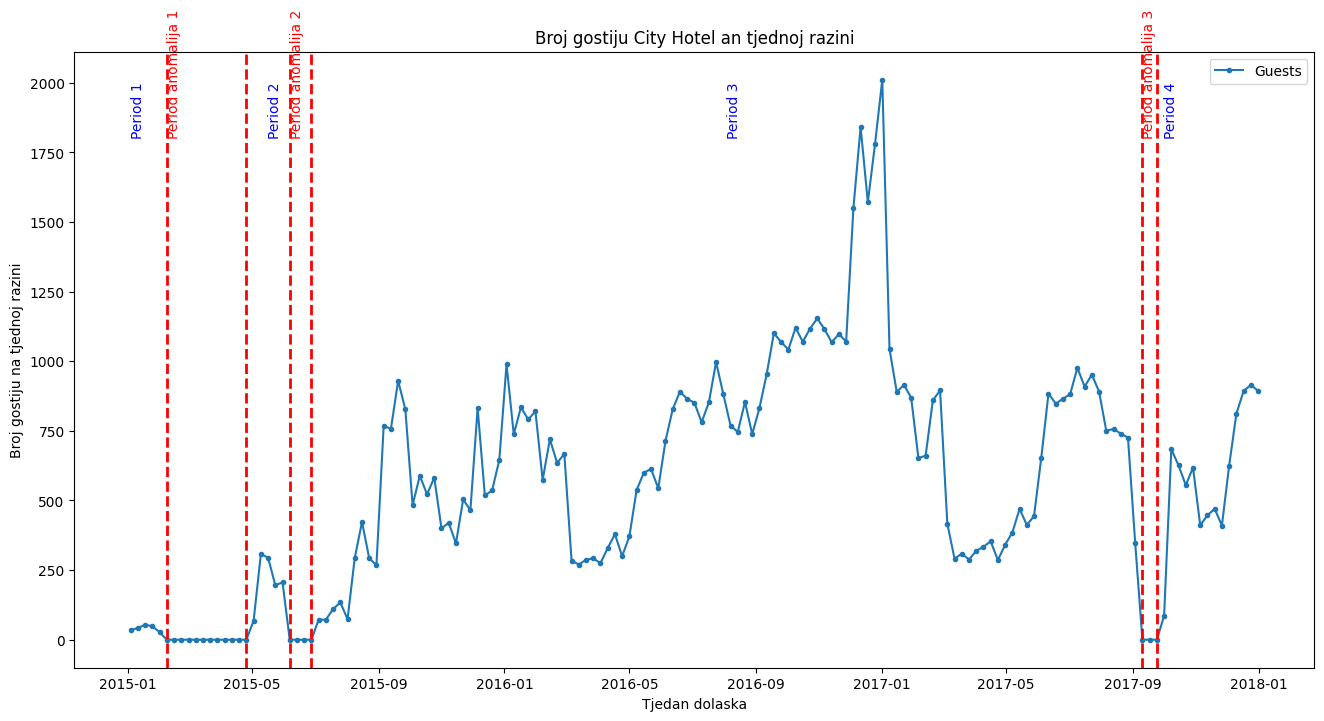

In [77]:
indexes = NumberOfGuestsWeeklyCity[NumberOfGuestsWeeklyCity['ukupno_gostiju'] == 0].index
periods = []
start_date = indexes[0]

for i in range(1, len(indexes)):
    if (indexes[i] - indexes[i - 1]).days > 7:  
        end_date = indexes[i - 1]
        periods.append((start_date, end_date))
        start_date = indexes[i]

periods.append((start_date, indexes[-1]))

plt.figure(figsize=(16, 8))
plt.plot(NumberOfGuestsWeeklyCity['ukupno_gostiju'], marker='.', label='Guests')

anomalous_period_count = 1
normal_period_count = 1

if periods[0][0] != NumberOfGuestsWeeklyCity.index.min():
    first_normal_end = periods[0][0] - pd.Timedelta(weeks=1)
    plt.text(NumberOfGuestsWeeklyCity.index.min(), max(NumberOfGuestsWeeklyCity['ukupno_gostiju']) * 0.9, f'Period {normal_period_count}', color='blue', rotation=90)
    normal_period_count += 1

for i, (start, end) in enumerate(periods):
    plt.axvline(x=start, color='red', linestyle='--', lw=2)
    plt.axvline(x=end, color='red', linestyle='--', lw=2)
    plt.text(start, max(NumberOfGuestsWeeklyCity['ukupno_gostiju']) * 0.9, f'Period anomalija {anomalous_period_count}', color='red', rotation=90)
    anomalous_period_count += 1

    if i < len(periods) - 1:
        next_start = periods[i + 1][0]
        midpoint = pd.to_datetime((end.value + next_start.value) // 2)
        plt.text(midpoint, max(NumberOfGuestsWeeklyCity['ukupno_gostiju']) * 0.9, f'Period {normal_period_count}', color='blue', rotation=90)
        normal_period_count += 1

if periods[-1][1] != NumberOfGuestsWeeklyCity.index.max():
    last_normal_start = periods[-1][1] + pd.Timedelta(weeks=1)
    plt.text(last_normal_start, max(NumberOfGuestsWeeklyCity['ukupno_gostiju']) * 0.9, f'Period {normal_period_count}', color='blue', rotation=90)
    normal_period_count += 1

plt.title('Broj gostiju City Hotel an tjednoj razini')
plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj gostiju na tjednoj razini')

plt.legend()
plt.show()


KOMENTAR
- period 1, 2 te 3 označavaju periode podatak iz dataseta gdje postoji dnevni broj gostiju različit od nule, dok periodi anomalija vremenske
periode gdje je ukupan broj gostiju jedan nuli
- prvi period anomalija ćemo izbaciti iz dataseta, kao i period 1 regularnih podataka, kako se radi o kratkom peroidu validnih podataka 
 (imamo 30 dana zapisa i 88 dana bez gostiju)
- drugi period anomalija, kao i treći, razrješiti će se na sljedeći način:
   - za drugi period anomalija gledati ćemo period 2 te određeni dio perioda 3 "zdravih podataka" te izračunati daily mean te dodati tu vrijednosti danima anomalija
   - za treći period koristiti ćemo dio trećeg te četvrtog perioda zdravih podataka i na taj način amputirati podatke u dane anomalija
- ovo se treba raditi na  podatkovnom okviru s dnevnim zapisima, kako na tjednoj razini ne vidimo veću granulaciju, odnosno postoje dani (jedan ili dva u nizu) u kojima 
  nema gostiju, ali koji se "ne vide" na tjednoj bazi,ali utječu na brog gostiju

#### Brisanje, umetanje podataka i vizualizacija

1.KORAK - brisanje podataka sve do kraja prvog područja anomalija - do 30-04-2015

In [78]:
cutoff_date = pd.to_datetime('2015-04-30')
dataCityClean = dataCity[dataCity['datum_dolaska'] >= cutoff_date]

In [79]:
NumberOfGuestsDailyCity = dataCityClean['ukupno_gostiju'].groupby(dataCityClean['datum_dolaska']).sum()
NumberOfGuestsDailyCity = NumberOfGuestsDailyCity.resample('d').sum().to_frame()
#NumberOfGuestsDailyCity.head(5)

Periodi gdje je broj gostiju jednak nuli : od 2015-06-01 do 2015-06-30, ukupno 29 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-05 do 2015-07-06, ukupno 1 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-12 do 2015-07-14, ukupno 2 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-19 do 2015-07-19, ukupno 0 dana
Periodi gdje je broj gostiju jednak nuli : od 2015-07-21 do 2015-07-21, ukupno 0 dana
Periodi gdje je broj gostiju jednak nuli : od 2017-09-01 do 2017-09-30, ukupno 29 dana


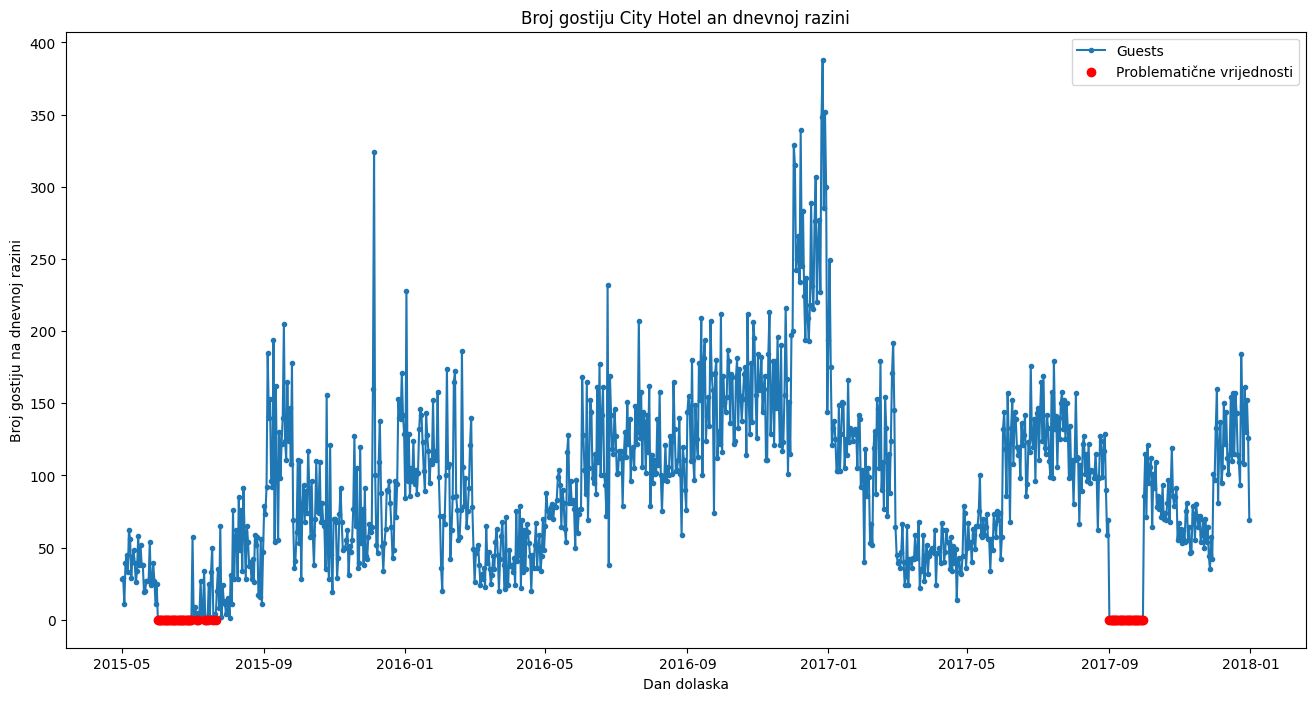

In [80]:
indexes = NumberOfGuestsDailyCity[NumberOfGuestsDailyCity['ukupno_gostiju'] == 0].index
periods = []
start_date = indexes[0]
for i in range(1, len(indexes)):
    if (indexes[i] - indexes[i-1]).days >1:
        end_date = indexes[i-1]
        periods.append((start_date, end_date))
        start_date = indexes[i]

periods.append((start_date, indexes[-1]))
for start, end in periods:
    print(f"Periodi gdje je broj gostiju jednak nuli : od {start.date()} do {end.date()}, ukupno {(end - start).days} dana")
    
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsDailyCity['ukupno_gostiju'], marker='.', label='Guests')
plt.plot(NumberOfGuestsDailyCity.loc[indexes, 'ukupno_gostiju'], 'o', color='red', label='Problematične vrijednosti')

plt.title('Broj gostiju City Hotel an dnevnoj razini')
plt.xlabel('Dan dolaska')
plt.ylabel('Broj gostiju na dnevnoj razini')

plt.legend()
plt.show()

2.KORAK -umetanje podataka

In [81]:
indexes_valid = NumberOfGuestsDailyCity[NumberOfGuestsDailyCity['ukupno_gostiju'] != 0].index
periods_valid = []
start_date = indexes_valid[0]
for i in range(1, len(indexes_valid)):
    if (indexes_valid[i] - indexes_valid[i-1]).days > 1:
        end_date = indexes_valid[i-1]
        periods_valid.append((start_date, end_date))
        start_date = indexes_valid[i]

periods_valid.append((start_date, indexes_valid[-1]))

for start, end in periods_valid:
    print(f"Periodi gdje je broj gostiju različit nuli : od {start.date()} do {end.date()}, ukupno {(end - start).days} dana")

Periodi gdje je broj gostiju različit nuli : od 2015-05-01 do 2015-05-31, ukupno 30 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-01 do 2015-07-04, ukupno 3 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-07 do 2015-07-11, ukupno 4 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-15 do 2015-07-18, ukupno 3 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-20 do 2015-07-20, ukupno 0 dana
Periodi gdje je broj gostiju različit nuli : od 2015-07-22 do 2017-08-31, ukupno 771 dana
Periodi gdje je broj gostiju različit nuli : od 2017-10-01 do 2017-12-31, ukupno 91 dana


In [85]:
def calculate_mean_for_window(start, end):
    window_data = NumberOfGuestsDailyCity[(NumberOfGuestsDailyCity.index >= start) & (NumberOfGuestsDailyCity.index <= end)]
    #print(window_data)
    return window_data['ukupno_gostiju'].mean()

In [83]:
for start, end in periods:
    period_length = (end - start).days

    if period_length == 1:
        window_start_before = start - pd.Timedelta(days=1)
        window_end_after = end + pd.Timedelta(days=1)
    elif period_length < 3:
        window_start_before = start - pd.Timedelta(days=4) #moguće mijenati veličinu prozora
        window_end_after = end + pd.Timedelta(days=4) #moguće mijenati veličinu prozora
    else:
        window_start_before = start - pd.Timedelta(days=6) #moguće mijenati veličinu prozora
        window_end_after = end + pd.Timedelta(days=6) #moguće mijenati veličinu prozora

    window_start_before = max(window_start_before, NumberOfGuestsDailyCity.index.min())
    window_end_after = min(window_end_after, NumberOfGuestsDailyCity.index.max())

    mean_before = calculate_mean_for_window(window_start_before, start - pd.Timedelta(days=1))
    mean_after = calculate_mean_for_window(end + pd.Timedelta(days=1), window_end_after)

    mean_value = (mean_before + mean_after) / 2

    for day in pd.date_range(start, end):
        if day in NumberOfGuestsDailyCity.index:
            variance_percentage = random.uniform(-0.2, 0.2)  # +/- 20%  varijance kako bismo simulirali stvarne podatke
            varied_mean_value = mean_value + (mean_value * variance_percentage)
            NumberOfGuestsDailyCity.at[day, 'ukupno_gostiju'] = varied_mean_value

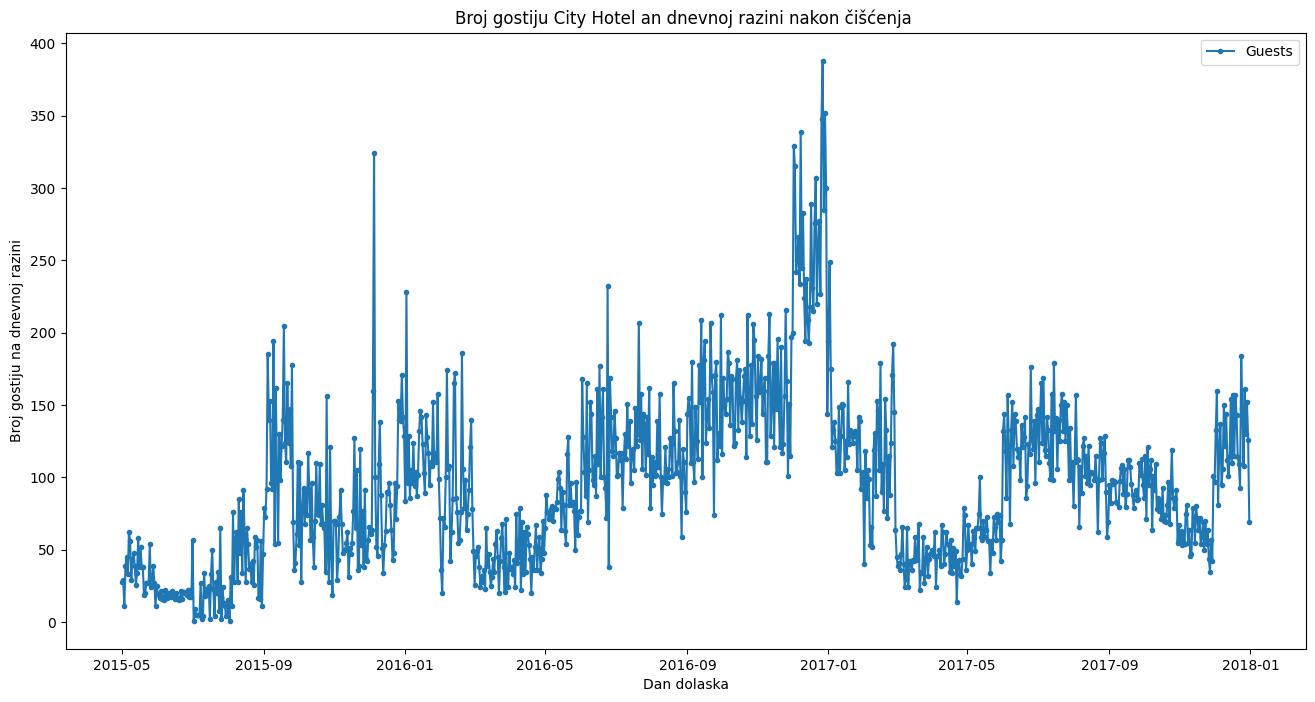

In [90]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsDailyCity['ukupno_gostiju'], marker='.', label='Guests')

plt.title('Broj gostiju City Hotel an dnevnoj razini nakon čišćenja ')
plt.xlabel('Dan dolaska')
plt.ylabel('Broj gostiju na dnevnoj razini')

plt.legend()
plt.show()

In [86]:
NumberOfGuestsWeeklyCity = NumberOfGuestsDailyCity.resample('W').sum()
NumberOfGuestsMonthlyCity = NumberOfGuestsDailyCity.resample('ME').sum()
NumberOfGuestsYearlyCity = NumberOfGuestsDailyCity.resample('Y').sum()


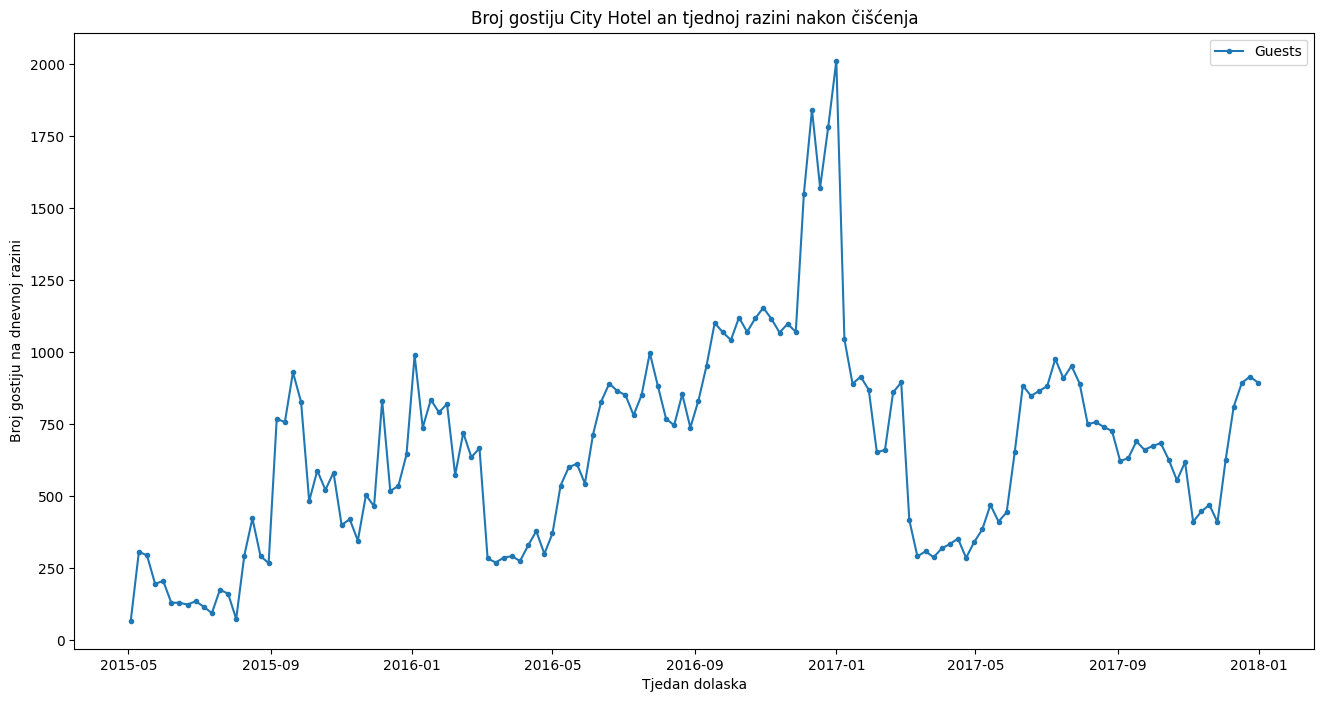

In [89]:
plt.figure(figsize=(16, 8))

plt.plot(NumberOfGuestsWeeklyCity['ukupno_gostiju'], marker='.', label='Guests')

plt.title('Broj gostiju City Hotel an tjednoj razini nakon čišćenja')
plt.xlabel('Tjedan dolaska')
plt.ylabel('Broj gostiju na dnevnoj razini')

plt.legend()
plt.show()

### Resort Hotel

In [91]:
NumberOfGuestsDailyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsDailyResort = NumberOfGuestsDailyResort.resample('d').sum().to_frame()
NumberOfGuestsDailyResort.head()

,ukupno_gostiju
datum_dolaska,
2015-07-01,67.0
2015-07-02,72.0
2015-07-03,59.0
2015-07-04,80.0
2015-07-05,80.0


#### Dnevna razina

In [92]:
NumberOfGuestsDailyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsDailyResort = NumberOfGuestsDailyResort.resample('d').sum().to_frame()
NumberOfGuestsDailyResort.head(5)

,ukupno_gostiju
datum_dolaska,
2015-07-01,67.0
2015-07-02,72.0
2015-07-03,59.0
2015-07-04,80.0
2015-07-05,80.0


#### Tjedna razina

In [93]:
NumberOfGuestsWeeklyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsWeeklyResort = NumberOfGuestsWeeklyResort.resample('w').sum().to_frame()
NumberOfGuestsWeeklyResort.head(5)

,ukupno_gostiju
datum_dolaska,
2015-07-05,358.0
2015-07-12,495.0
2015-07-19,537.0
2015-07-26,533.0
2015-08-02,554.0


#### Mjesečna razina

In [94]:
NumberOfGuestsMonthlyResort =  dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsMonthlyResort = NumberOfGuestsMonthlyResort.resample('m').sum().to_frame()
NumberOfGuestsMonthlyResort.head(5)

,ukupno_gostiju
datum_dolaska,
2015-07-31,2300.0
2015-08-31,2318.0
2015-09-30,2013.0
2015-10-31,2108.0
2015-11-30,1534.0


#### Godišnja razina

In [95]:
NumberOfGuestsYearlyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsYearlyResort = NumberOfGuestsYearlyResort.resample('y').sum().to_frame()
NumberOfGuestsYearlyResort.head(5)

,ukupno_gostiju
datum_dolaska,
2015-12-31,12053.0
2016-12-31,26091.0
2017-12-31,17816.0


# ARIMA model za predviđanje budućeg broja gostiju - City Hotel

## Predviđanje dnevnog broja gostiju 


#### Dickey-Fuller test za podatke o dnevnom broju gostiju

##### Augmented Dickey-Fuller (ADF) test se koristi u statistici i ekonometriji za testiranje prisutnosti tzv. "jediničnog korijena" (unit root) u vremenskim serijama
##### Jedinični korijen ukazuje na to da vremenska serija nije stacionarna, što znači da njene statističke karakteristike kao što su srednja vrijednost, varijanca i autokorelacija, se mijenjaju tijekom vremena
##### Nulta hipoteza (H0): Postoji jedinični korijen, tj. serija je nestacionarna.
##### Alternativna hipoteza (H1): Ne postoji jedinični korijen, tj. serija je stacionarna.

In [96]:
CityDailyValues = NumberOfGuestsDailyCity.values
result_city_daily = adfuller(CityDailyValues)
print('ADF Statistic: %f' % result_city_daily[0])
print('p-value: %f' % result_city_daily[1])
print('Critical Values:')
for key, value in result_city_daily[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.739235
p-value: 0.067492
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost veća od alfe, ne možemo odbaciti H0, odnosno serija je nestacionarna 

#### Rollling Mean i STD City Hotela

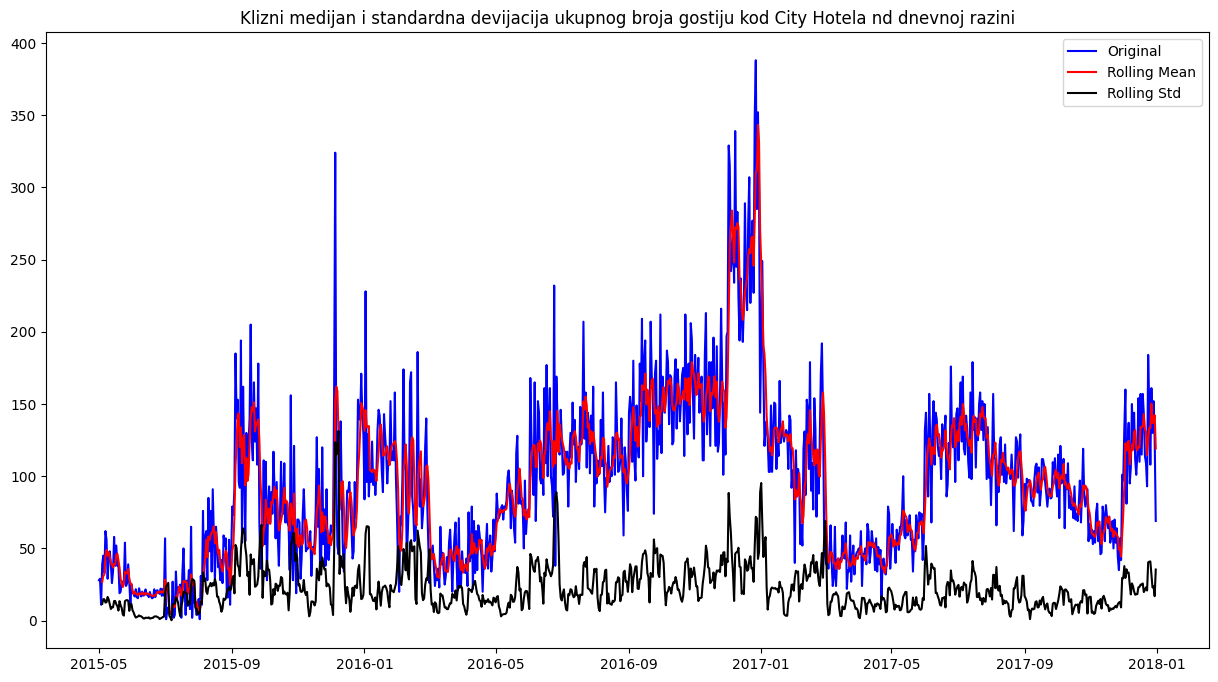

In [98]:
plt.figure(figsize=(15, 8))
rolling_mean_city_daily = NumberOfGuestsDailyCity.rolling(window=4).mean()
rolling_std_city_daily = NumberOfGuestsDailyCity.rolling(window=4).std()
plt.plot(NumberOfGuestsDailyCity, color='blue', label='Original')
plt.plot(rolling_mean_city_daily, color='red', label='Rolling Mean')
plt.plot(rolling_std_city_daily, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Klizni medijan i standardna devijacija ukupnog broja gostiju kod City Hotela nd dnevnoj razini')
plt.show()

#### Train / test split podataka

In [99]:
split_ratio  =  0.8

In [100]:
train_test_split_city_daily = int(len(NumberOfGuestsDailyCity)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_city_daily} podataka, test {len(NumberOfGuestsDailyCity)-train_test_split_city_daily} podataka")

trainCityDaily = NumberOfGuestsDailyCity[:train_test_split_city_daily]
testCityDaily = NumberOfGuestsDailyCity[train_test_split_city_daily:]

Split 0.8 na train/test, train ima 780 podataka, test 196 podataka


#### Fit ARIMA modela na podatke na dnevnoj bazi

- Iz službene dokumentacije (https://alkaline-ml.com/pmdarima/tips_and_tricks.html#period):
   - The m parameter relates to the number of observations per seasonal cycle, and is one that must be known apriori. Typically, m will correspond to some recurrent periodicity such as:
    - 7 - daily
    - 12 - monthly
    - 52 - weekly

- parametar 'd' koristi se ako je potrebno diferencirati vremensku seriju, odnosno postavljamo ga na None ako ne znamo kako diferencirati podatke,
a inače na int vrijednost (tipično 1). Zaklkučak o tome izvodimo iz Augmented Dickey-Fuller Test koji testira jesu li neki podaci u vremenskoj seriji 
stacionarni ili nisu

- Vremenska je serija stacionarna kada su joj  medijan, varijanca, auto-korelacija i slične metrike konstante kroz vrijeme t.
ARIMA pretpostavlja da podaci postaju stacionarni nako diferenciranja, ukoliko je d postavljen an vrijednost veću od nule, što
se naziva diferencijablna stacionarnost. auto_arima određuje i optimalni d.

In [101]:
stepwise_fit_city_daily = auto_arima(trainCityDaily['ukupno_gostiju'],
                          start_p=1, start_q=1,
                          max_p=5, max_q=5, m=7,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_city_daily.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=8097.022, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=7864.290, Time=1.26 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=7835.970, Time=0.75 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=8095.249, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=8019.028, Time=0.49 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=7834.159, Time=1.30 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=7906.799, Time=1.03 sec
 ARIMA(0,0,1)(2,1,1)[7] intercept   : AIC=inf, Time=4.95 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=7834.509, Time=5.20 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=7833.681, Time=3.74 sec
 ARIMA(0,0,0)(0,1,2)[7] intercept   : AIC=7958.265, Time=2.70 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=inf, Time=8.83 sec
 ARIMA(0,0,2)(0,1,2)[7] intercept   : AIC=7787.697, Time=3.91 sec
 ARIMA(0,0,2)(0,1,1)[7] intercept   : AIC=7790.2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  780
Model:             SARIMAX(0, 0, 5)x(1, 1, [1], 7)   Log Likelihood               -3842.533
Date:                             Thu, 22 Feb 2024   AIC                           7701.067
Time:                                     21:28:53   BIC                           7738.269
Sample:                                 05-01-2015   HQIC                          7715.381
                                      - 06-18-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3142      0.028     11.194      0.000       0.259       0.369
ma.L2          0.2721      0.029      9.488      0.000       0.216       0.328
ma.L3          0.2837      0.030      9.504      0.000       0.225       0.342
ma.L4          0.2307      0.030      7.628      0.000       0.171       0.290
ma.L5          0.1913      0.029      6.711      0.000       0.135       0.247
ar.S.L7        0.2272      0.046      4.912      0.000       0.137       0.318
ma.S.L7       -0.8425      0.028    -29.917      0.000      -0.898      -0.787
sigma2      1205.9038     36.011     33.487      0.000    1135.324    1276.483
===================================================================================
Ljung-Box (L1) (Q):                   1.42   Jarque-Bera (JB):               869.42
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             0.97
Prob(H) (two-sided):                  0.25   Kurtosis:                         7.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(0,0,5)(1,1,1)[7]     je najbolji model te se to preslikava u parametre
- order = (0,0,5)
- seasonal_order = (1,1,1,7)

In [103]:
modelCity_daily = ARIMA(trainCityDaily['ukupno_gostiju'],
                  order=(0,0,5),
                  seasonal_order=(1, 1, 1, 7))

resultCity_daily = modelCity_daily.fit()


##### Predikcije modela na test podacima na dnevnoj bazi

In [104]:
predictionsCityTestDaily = resultCity_daily.predict(train_test_split_city_daily, train_test_split_city_daily + len(testCityDaily) - 1, typ='levels').rename("Predictions")


### Predikcija broja gostija na dnevnoj razini na testnim podacima


Text(0, 0.5, 'Broj gostiju')

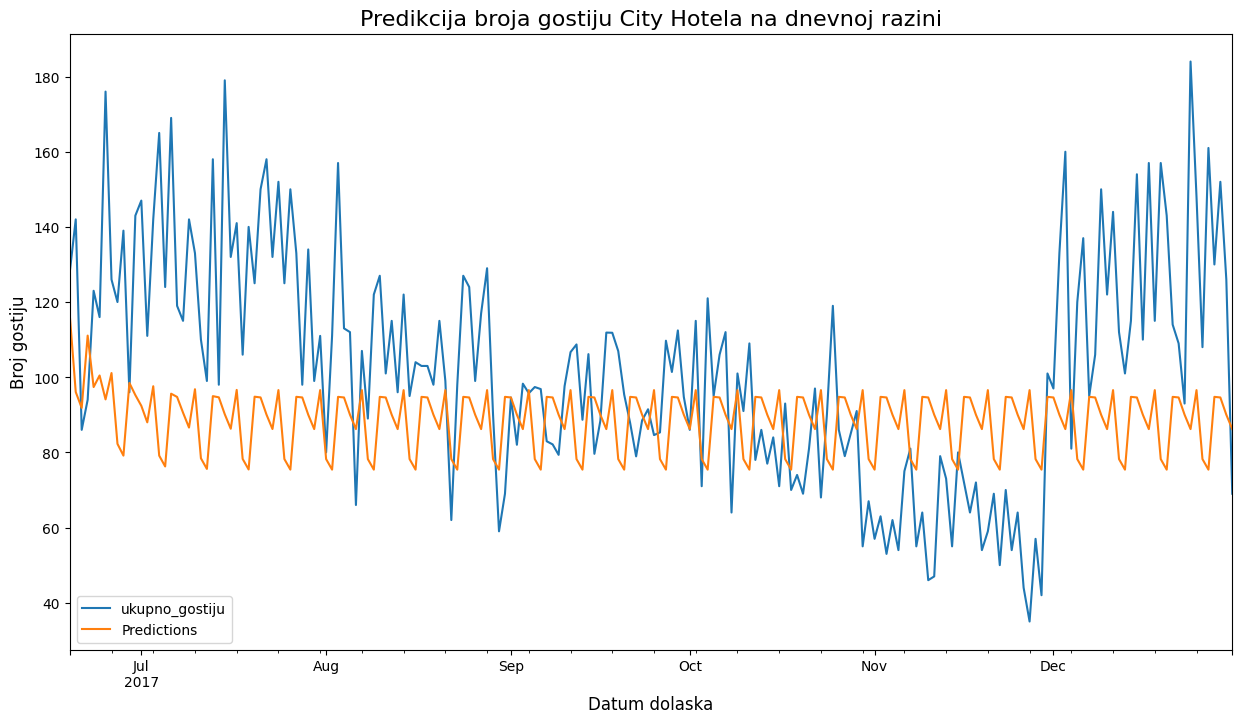

In [105]:
plt.figure(figsize=(15, 8))
testCityDaily['ukupno_gostiju'].plot(legend=True)
predictionsCityTestDaily.plot(legend=True)
plt.title('Predikcija broja gostiju City Hotela na dnevnoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

Text(0, 0.5, 'Broj gostiju')

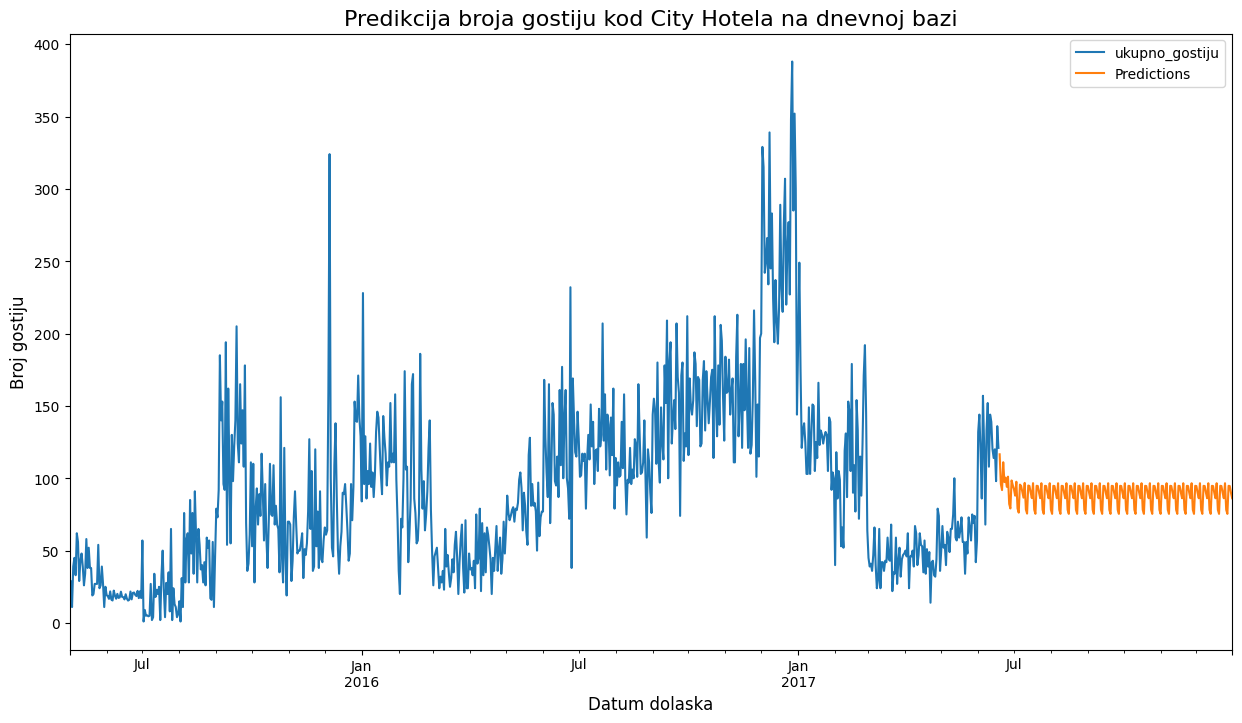

In [106]:
plt.figure(figsize=(15, 8))
trainCityDaily['ukupno_gostiju'].plot(legend=True)
predictionsCityTestDaily.plot(legend=True)
plt.title('Predikcija broja gostiju kod City Hotela na dnevnoj bazi', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [122]:
MeanAbsPercentageErrCityDaily_test = mean_absolute_percentage_error(testCityDaily, predictionsCityTestDaily)
MeanSquaredErrCityDaily_test = mean_squared_error(testCityDaily, predictionsCityTestDaily)
RootMeanSquaredErrCityDaily_test = root_mean_squared_error(testCityDaily, predictionsCityTestDaily)
print('Test MAPE City Hotel na dnevnoj razini: %f' % MeanAbsPercentageErrCityDaily_test)
print('Test MSE City Hotel na dnevnoj razini: %f' % MeanSquaredErrCityDaily_test )
print('Test RMSE City Hotel na dnevnoj razini: %f' % RootMeanSquaredErrCityDaily_test )

Test MAPE City Hotel na dnevnoj razini: 0.269380
Test MSE City Hotel na dnevnoj razini: 1163.264705
Test RMSE City Hotel na dnevnoj razini: 34.106667


## Predviđanje tjednog broja gostiju 


#### Dickey-Fuller test za podatke o dnevnom broju gostiju

In [108]:
CityWeeklyValues = NumberOfGuestsWeeklyCity.values
result_city_weekly = adfuller(CityWeeklyValues)
print('ADF Statistic: %f' % result_city_weekly[0])
print('p-value: %f' % result_city_weekly[1])
print('Critical Values:')
for key, value in result_city_weekly[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.769025
p-value: 0.062836
Critical Values:
	1%: -3.480
	5%: -2.883
	10%: -2.578


- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost veća od alfe, ne možemo odbaciti H0, odnosno serija je nestacionarna 

#### Rollling Mean i STD City Hotela

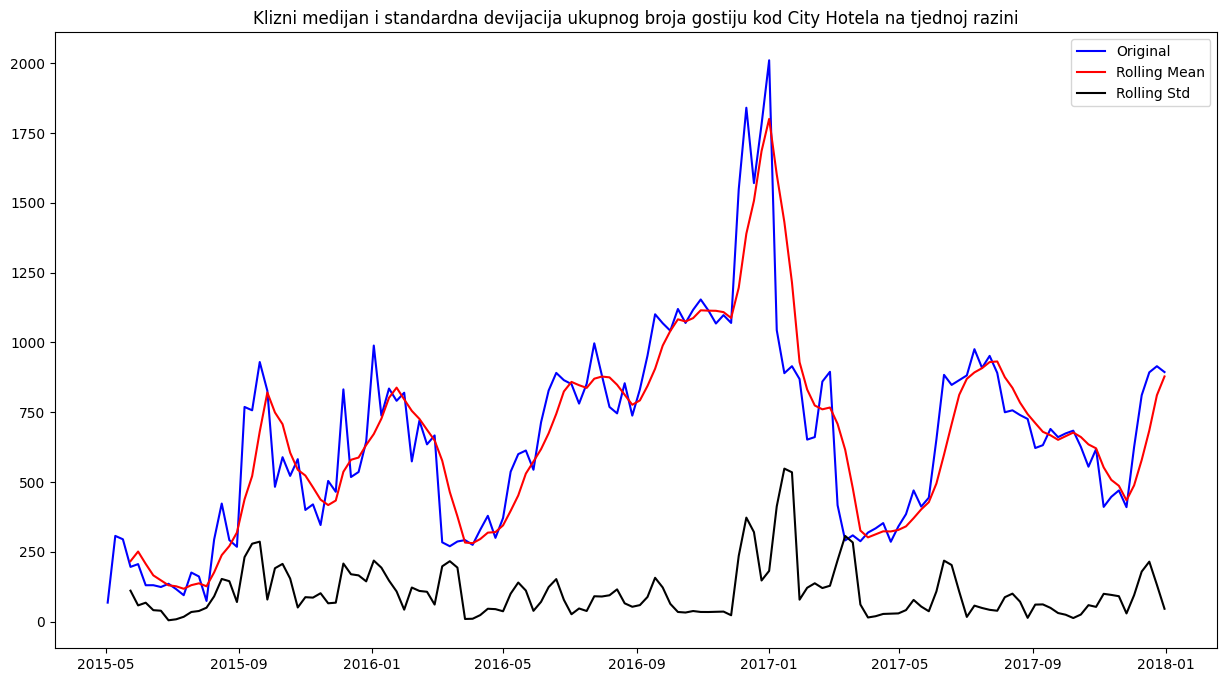

In [109]:
plt.figure(figsize=(15, 8))
rolling_mean_city_weekly = NumberOfGuestsWeeklyCity.rolling(window=4).mean()
rolling_std_city_weekly = NumberOfGuestsWeeklyCity.rolling(window=4).std()
plt.plot(NumberOfGuestsWeeklyCity, color='blue', label='Original')
plt.plot(rolling_mean_city_weekly, color='red', label='Rolling Mean')
plt.plot(rolling_std_city_weekly, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Klizni medijan i standardna devijacija ukupnog broja gostiju kod City Hotela na tjednoj razini')
plt.show()

In [110]:
split_ratio  =  0.8

In [111]:
train_test_split_city_weekly = int(len(NumberOfGuestsWeeklyCity)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_city_weekly} podataka, test {len(NumberOfGuestsWeeklyCity)-train_test_split_city_weekly} podataka")

trainCityWeekly = NumberOfGuestsWeeklyCity[:train_test_split_city_weekly]
testCityWeekly = NumberOfGuestsWeeklyCity[train_test_split_city_weekly:]

Split 0.8 na train/test, train ima 112 podataka, test 28 podataka


#### Fit ARIMA modela na podatke na tjednoj bazi

In [112]:
stepwise_fit_city_weekly = auto_arima(trainCityWeekly['ukupno_gostiju'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=52,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_city_weekly.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=inf, Time=17.91 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=783.440, Time=0.51 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=786.841, Time=7.07 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=14.69 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=784.889, Time=5.59 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=inf, Time=9.89 sec
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=inf, Time=17.77 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=785.436, Time=0.55 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=785.435, Time=0.64 sec
 ARIMA(1,1,1)(0,1,0)[52]             : AIC=787.210, Time=1.11 sec
 ARIMA(0,1,0)(0,1,0)[52] intercept   : AIC=785.379, Time=0.35 sec

Best model:  ARIMA(0,1,0)(0,1,0)[52]          
Total fit time: 76.119 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  112
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 52)   Log Likelihood                -390.720
Date:                            Thu, 22 Feb 2024   AIC                            783.440
Time:                                    21:31:57   BIC                            785.518
Sample:                                05-03-2015   HQIC                           784.251
                                     - 06-18-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.308e+04   3403.322      9.720      0.000    2.64e+04    3.98e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                48.64
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                            -0.46
Prob(H) (two-sided):                  0.02   Kurtosis:                         7.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(0,1,0)(0,1,0)[52] je najbolji model te se to preslikava u parametre
- order = (0,1,0)
- seasonal_order = (0,1,0,52)

In [113]:
modelCityWeekly = ARIMA(trainCityWeekly['ukupno_gostiju'],
                  order=(0, 1, 0),
                  seasonal_order=(0, 1, 0, 52))

resultCityWeekly = modelCityWeekly.fit()


##### Predikcije modela na test podacima na tjednoj bazi

In [114]:
predictionsCityTestWeekly = resultCityWeekly.predict(train_test_split_city_weekly, train_test_split_city_weekly + len(testCityWeekly) - 1, typ='levels').rename("Predictions")


### Predikcija broja gostija na tjednoj razini na testnim podacima


Text(0, 0.5, 'Broj gostiju')

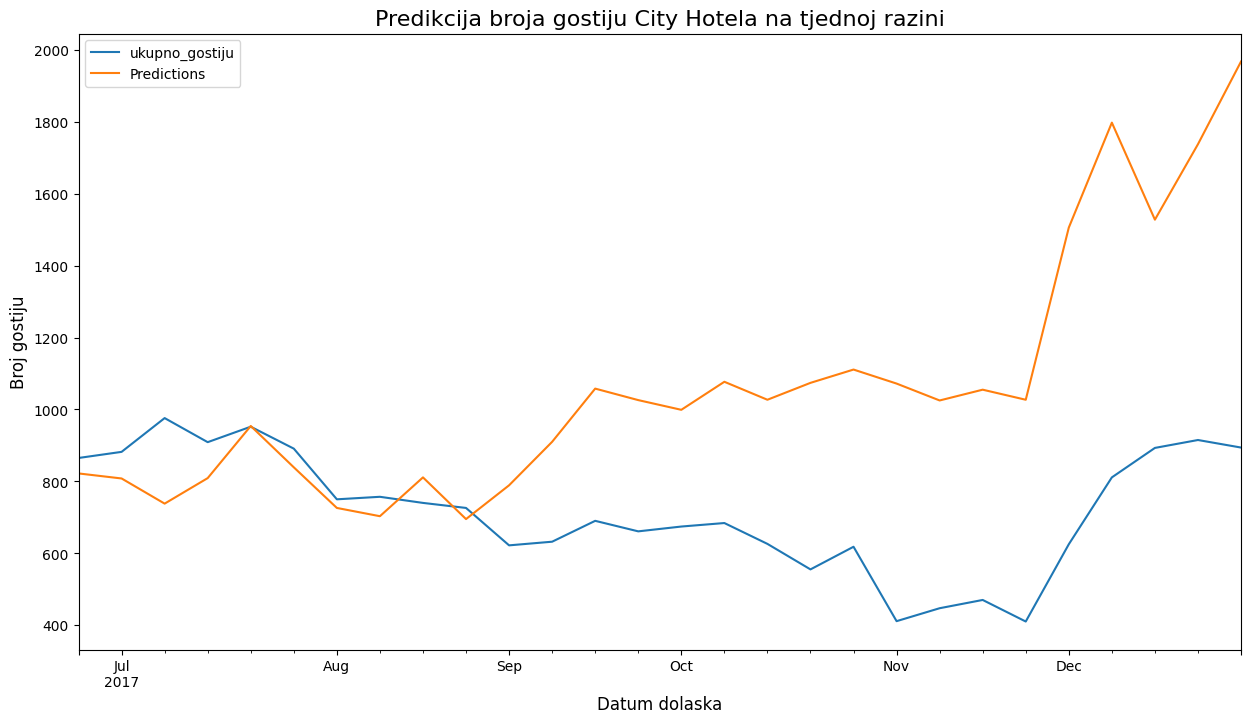

In [115]:
plt.figure(figsize=(15, 8))
testCityWeekly['ukupno_gostiju'].plot(legend=True)
predictionsCityTestWeekly.plot(legend=True)
plt.title('Predikcija broja gostiju City Hotela na tjednoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

### Predikcija broja gostiju na tjednoj razini

Text(0, 0.5, 'Broj gostiju')

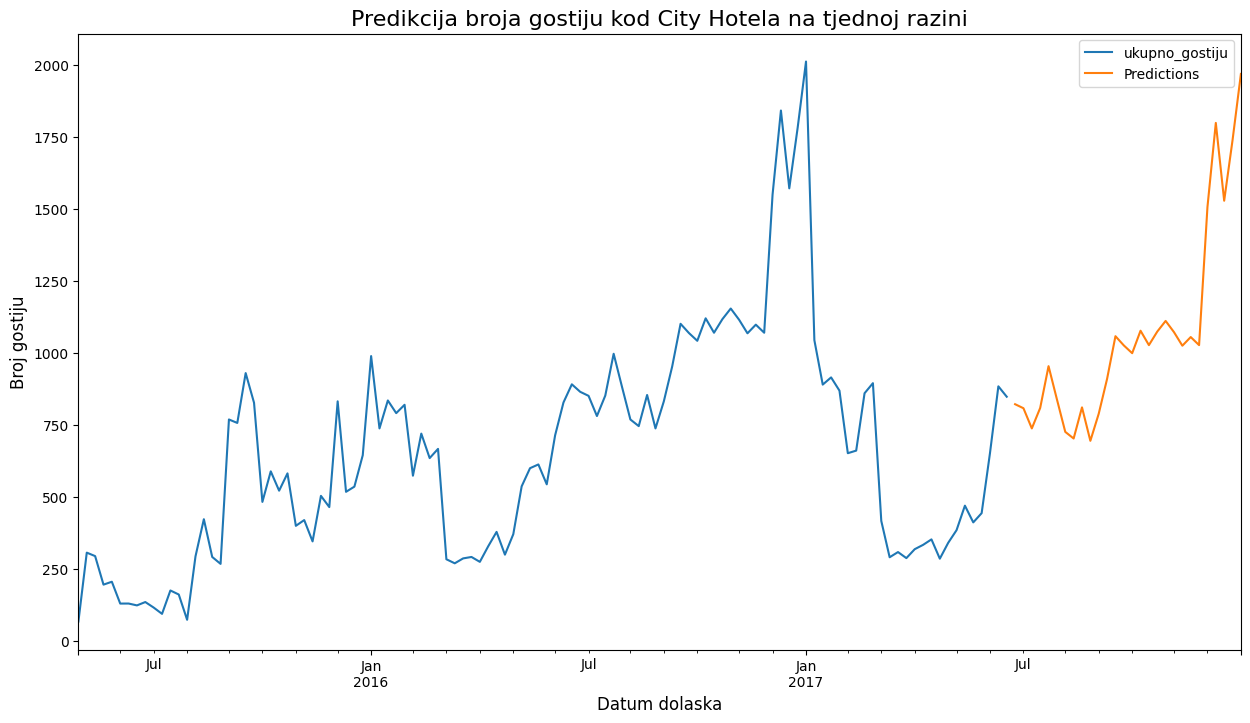

In [116]:
plt.figure(figsize=(15, 8))
trainCityWeekly['ukupno_gostiju'].plot(legend=True)
predictionsCityTestWeekly.plot(legend=True)
plt.title('Predikcija broja gostiju kod City Hotela na tjednoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [123]:
MeanAbsPercentageErrCityWeekly_test = mean_absolute_percentage_error(testCityWeekly, predictionsCityTestWeekly)
MeanSquaredErrCityWeekly_test = mean_squared_error(testCityWeekly, predictionsCityTestWeekly)
RootMeanSquaredErrCityWeekly_test = root_mean_squared_error(testCityWeekly, predictionsCityTestWeekly)
print('Test MAPE City Hotel tjedna razina: %f' % MeanAbsPercentageErrCityWeekly_test)
print('Test MSE City Hotel tjedna razina: %f' % MeanSquaredErrCityWeekly_test )
print('Test RMSE City Hotel tjedna razina: %f' % RootMeanSquaredErrCityWeekly_test )

Test MAPE City Hotel tjedna razina: 0.610819
Test MSE City Hotel tjedna razina: 245406.918078
Test RMSE City Hotel tjedna razina: 495.385626


## Predviđanje mjesečnog broja gostiju 


#### Dickey-Fuller test za podatke o mjesečnombroju gostiju

In [124]:
CityMonthlyValues = NumberOfGuestsMonthlyCity.values
result_city_monthly = adfuller(CityMonthlyValues)
print('ADF Statistic: %f' % result_city_monthly [0])
print('p-value: %f' % result_city_monthly [1])
print('Critical Values:')
for key, value in result_city_monthly [4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.781950
p-value: 0.060899
Critical Values:
	1%: -3.661
	5%: -2.961
	10%: -2.619


- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost veća od alfe, ne možemo odbaciti H0, odnosno serija je nestacionarna 

#### Rollling Mean i STD City Hotela Mjesečna razina

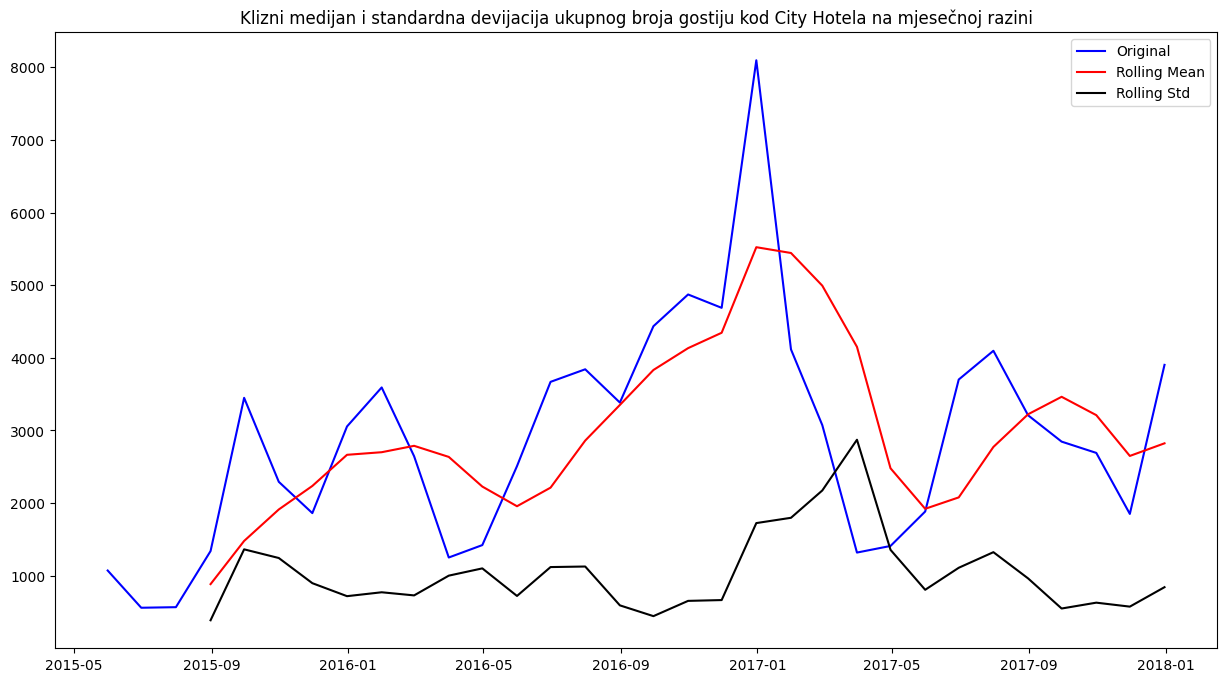

In [125]:
plt.figure(figsize=(15, 8))
rolling_mean_city_monthly  = NumberOfGuestsMonthlyCity.rolling(window=4).mean()
rolling_std_city_monthly = NumberOfGuestsMonthlyCity.rolling(window=4).std()
plt.plot(NumberOfGuestsMonthlyCity, color='blue', label='Original')
plt.plot(rolling_mean_city_monthly, color='red', label='Rolling Mean')
plt.plot(rolling_std_city_monthly, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Klizni medijan i standardna devijacija ukupnog broja gostiju kod City Hotela na mjesečnoj razini')
plt.show()

In [126]:
split_ratio  =  0.8

In [127]:
train_test_split_city_monthly = int(len(NumberOfGuestsMonthlyCity)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_city_monthly} podataka, test {len(NumberOfGuestsMonthlyCity)-train_test_split_city_monthly} podataka")

trainCityMonthly = NumberOfGuestsMonthlyCity[:train_test_split_city_monthly]
testCityMonthly = NumberOfGuestsMonthlyCity[train_test_split_city_monthly:]

Split 0.8 na train/test, train ima 25 podataka, test 7 podataka


#### Fit ARIMA modela na podatke na mjesečnoj bazi

In [128]:
stepwise_fit_city_monthly = auto_arima(trainCityMonthly['ukupno_gostiju'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_city_monthly.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=235.615, Time=0.42 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=232.347, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=233.548, Time=0.25 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=234.508, Time=0.25 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=240.107, Time=0.04 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=234.345, Time=0.08 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=234.337, Time=0.06 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=236.337, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=231.733, Time=0.03 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=233.608, Time=0.07 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=235.536, Time=0.24 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=233.760, Time=0.11 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=233.797, Time=0.11 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=232.353, Time=0.12 sec
 ARIMA(2,0,1)(0,1,0)[12] intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   25
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -113.651
Date:                            Thu, 22 Feb 2024   AIC                            231.302
Time:                                    21:34:32   BIC                            232.432
Sample:                                05-31-2015   HQIC                           231.070
                                     - 05-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7422      0.135      5.490      0.000       0.477       1.007
sigma2      2.437e+06   1.04e+06      2.348      0.019    4.03e+05    4.47e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):                 0.65
Prob(Q):                              0.48   Prob(JB):                         0.72
Heteroskedasticity (H):               0.08   Skew:                            -0.45
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(1,0,0)(0,1,0)[12] je najbolji model te se to preslikava u parametre
- order = (1,0,0)
- seasonal_order = (0,1,0,12)

In [129]:
modelCityMonthly = ARIMA(trainCityMonthly['ukupno_gostiju'],
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 0, 12))

resultCityMonthly = modelCityMonthly.fit()


##### Predikcije modela na test podacima na mjesečnoj bazi

In [130]:
predictionsCityTestMonthly = resultCityMonthly.predict(train_test_split_city_monthly, train_test_split_city_monthly + len(testCityMonthly) - 1, typ='levels').rename("Predictions")


### Predikcija broja gostija na mjesečnoj razini na testnim podacima


Text(0, 0.5, 'Broj gostiju')

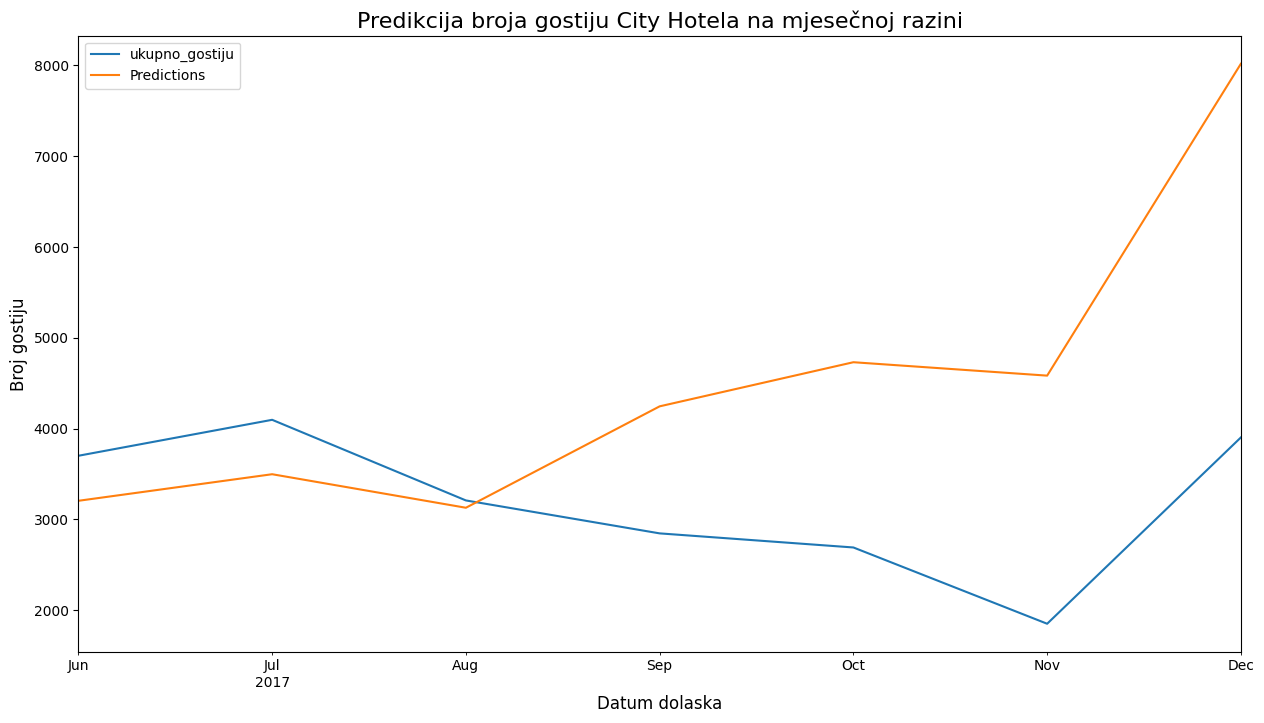

In [131]:
plt.figure(figsize=(15, 8))
testCityMonthly['ukupno_gostiju'].plot(legend=True)
predictionsCityTestMonthly.plot(legend=True)
plt.title('Predikcija broja gostiju City Hotela na mjesečnoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

### Predikcija broja gostiju na mjesečnoj razini

Text(0, 0.5, 'Broj gostiju')

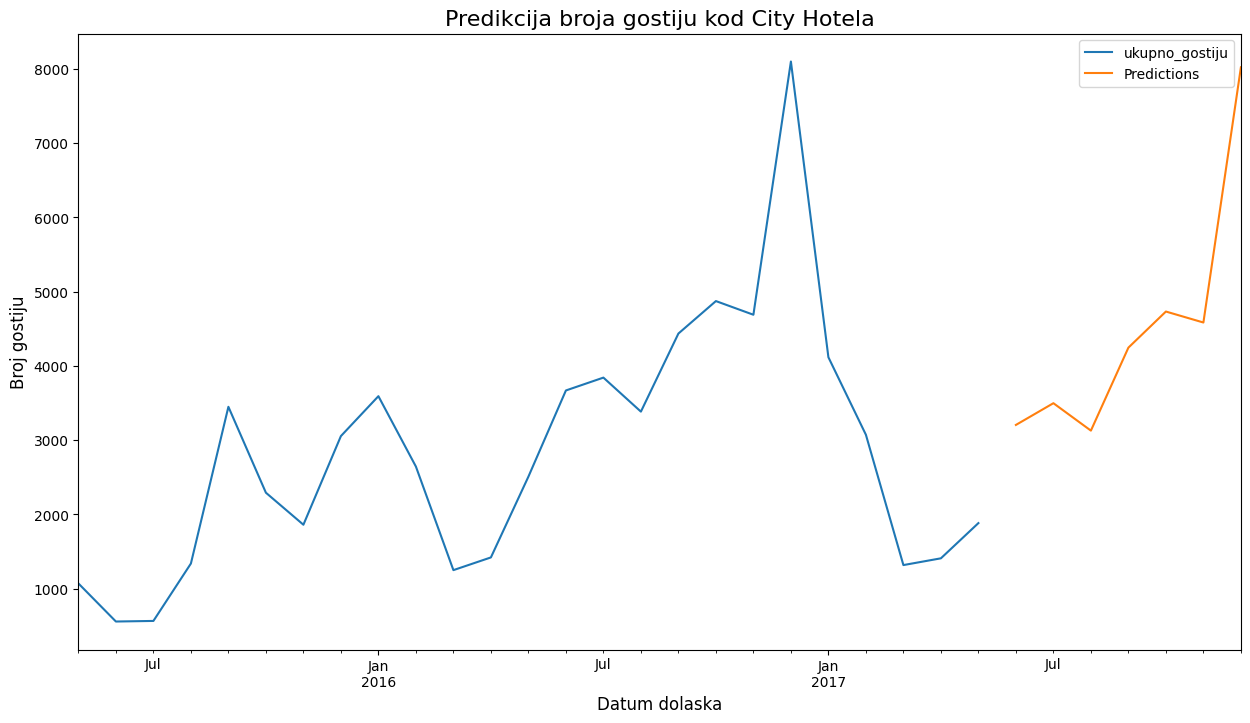

In [132]:
plt.figure(figsize=(15, 8))
trainCityMonthly['ukupno_gostiju'].plot(legend=True)
predictionsCityTestMonthly.plot(legend=True)
plt.title('Predikcija broja gostiju kod City Hotela', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [134]:
MeanAbsPercentageErrCityMonthly_test = mean_absolute_percentage_error(testCityMonthly, predictionsCityTestMonthly)
MeanSquaredErrCityMonthly_test = mean_squared_error(testCityMonthly, predictionsCityTestMonthly)
RootMeanSquaredErrCityMonthly_test = root_mean_squared_error(testCityMonthly, predictionsCityTestMonthly)
print('Test MAPE City Hotel mjesečna razina: %f' % MeanAbsPercentageErrCityMonthly_test)
print('Test MSE City Hotel mjesečna razina: %f' % MeanSquaredErrCityMonthly_test )
print('Test RMSE City Hotel mjesečna razina: %f' % RootMeanSquaredErrCityMonthly_test )

Test MAPE City Hotel mjesečna razina: 0.583682
Test MSE City Hotel mjesečna razina: 4447887.766771
Test RMSE City Hotel mjesečna razina: 2109.001604


# ARIMA model za predviđanje budućeg broja gostiju - Resort Hotel 


## Predviđanje dnevnog broja gostiju 


#### Dickey-Fuller test za podatke o dnevnom broju gostiju

In [135]:
ResortDailyValues = NumberOfGuestsDailyResort.values
result_resort_daily = adfuller(ResortDailyValues)
print('ADF Statistic: %f' % result_resort_daily[0])
print('p-value: %f' % result_resort_daily[1])
print('Critical Values:')
for key, value in result_resort_daily[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.565566
p-value: 0.000149
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost manja od alfe,  možemo odbaciti H0, odnosno serija je stacionarna 

#### Rollling Mean i STD Resort Hotela na dnevnioj razini

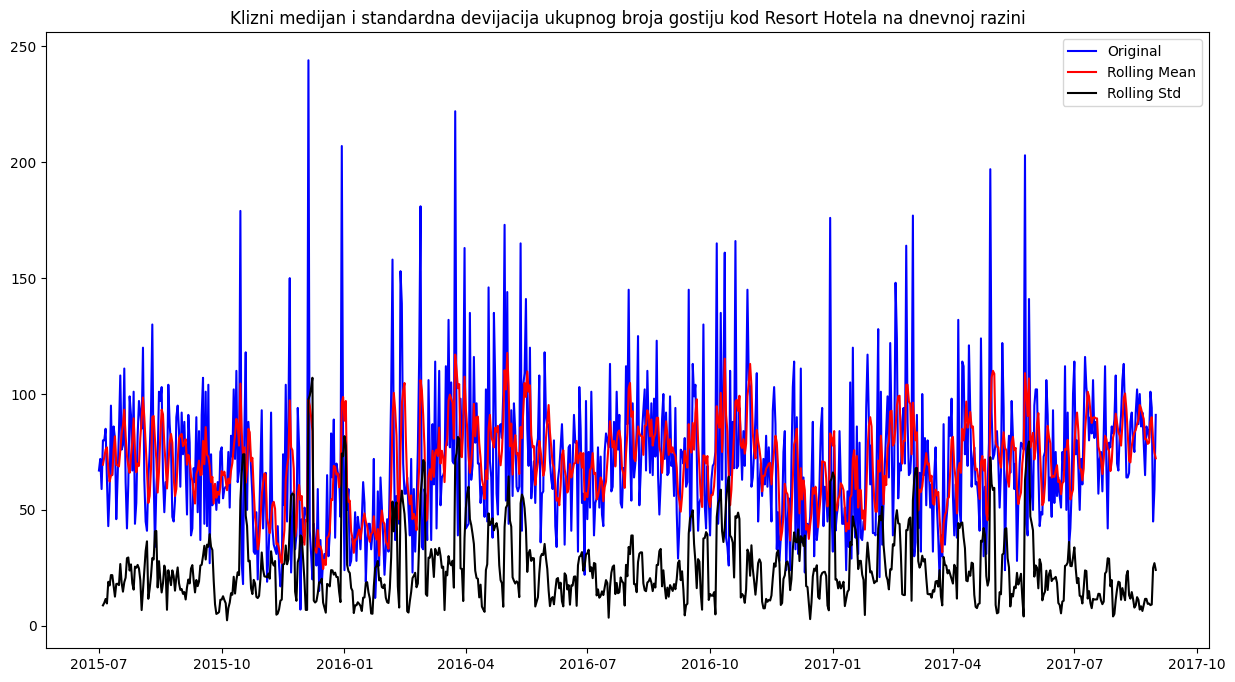

In [136]:
plt.figure(figsize=(15, 8))
rolling_mean_resort_daily = NumberOfGuestsDailyResort.rolling(window=4).mean()
rolling_std_resort_daily  = NumberOfGuestsDailyResort.rolling(window=4).std()
plt.plot(NumberOfGuestsDailyResort, color='blue', label='Original')
plt.plot(rolling_mean_resort_daily , color='red', label='Rolling Mean')
plt.plot(rolling_std_resort_daily , color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Klizni medijan i standardna devijacija ukupnog broja gostiju kod Resort Hotela na dnevnoj razini')
plt.show()

In [137]:
split_ratio  =  0.8

In [138]:
train_test_split_resort_daily = int(len(NumberOfGuestsDailyResort)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_resort_daily} podataka, test {len(NumberOfGuestsDailyResort)-train_test_split_resort_daily} podataka")

trainResortDaily = NumberOfGuestsDailyResort[:train_test_split_resort_daily]
testResortDaily = NumberOfGuestsDailyResort[train_test_split_resort_daily:]

Split 0.8 na train/test, train ima 634 podataka, test 159 podataka


#### Fit ARIMA modela na podatke na dnevnoj bazi

In [139]:
stepwise_fit_resort_daily = auto_arima(trainResortDaily['ukupno_gostiju'], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=7,
                          start_P=0, seasonal=True,
                          d=0, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_resort_daily.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=6063.789, Time=1.45 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=6341.594, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=6176.142, Time=0.83 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=6062.540, Time=1.00 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=6339.624, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=6340.951, Time=0.25 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=1.72 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=inf, Time=2.66 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=6175.946, Time=0.53 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=9.22 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=6071.644, Time=0.42 sec
 ARIMA(0,0,2)(0,1,1)[7] intercept   : AIC=6064.322, Time=1.84 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=6062.920, Time=1.21 sec
 ARIMA(1,0,2)(0,1,1)[7] intercept   : AIC=6065.609, Time=3.12 sec
 ARIMA(0,0,1)(0,1,1)[7]             : AIC=6060.6

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  634
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -3027.326
Date:                           Thu, 22 Feb 2024   AIC                           6060.653
Time:                                   21:36:47   BIC                           6073.976
Sample:                               07-01-2015   HQIC                          6065.829
                                    - 03-25-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1394      0.036      3.901      0.000       0.069       0.209
ma.S.L7       -0.8485      0.022    -39.392      0.000      -0.891      -0.806
sigma2       901.8391     29.013     31.084      0.000     844.974     958.704
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               652.42
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             1.31
Prob(H) (two-sided):                  0.46   Kurtosis:                         7.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(0,0,1)(0,1,1)[7]    je najbolji model te se to preslikava u parametre
- order = (0, 0 ,1)
- seasonal_order = (0,1,1,7)


In [140]:
modelResort_daily = ARIMA(trainResortDaily['ukupno_gostiju'],
                  order=(0, 0, 1),
                  seasonal_order=(0, 1, 1, 7))

resultResort_daily = modelResort_daily.fit()


##### Predikcije modela na test podacima na dnevnoj bazi

In [141]:
predictionsResortTestDaily = resultResort_daily.predict(train_test_split_resort_daily, train_test_split_resort_daily + len(testResortDaily) - 1, typ='levels').rename("Predictions")


### Predikcija broja gostija na dnevnoj razini na testnim podacima


Text(0, 0.5, 'Broj gostiju')

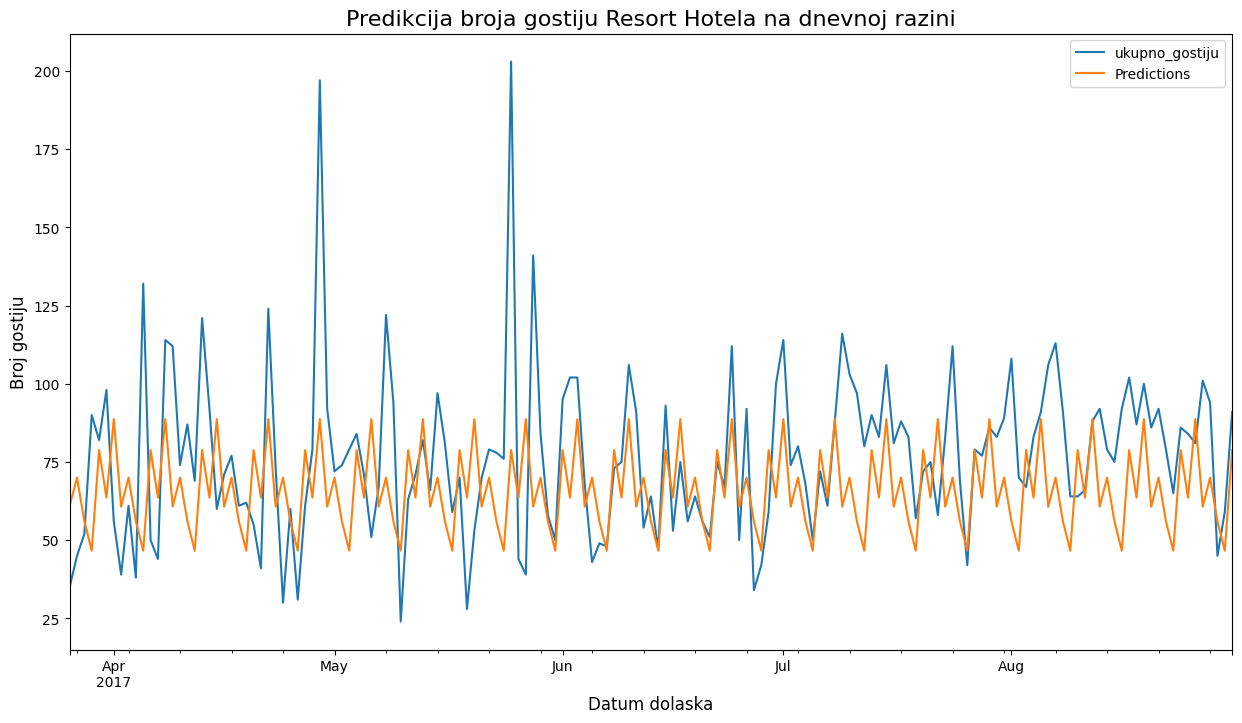

In [142]:
plt.figure(figsize=(15, 8))
testResortDaily['ukupno_gostiju'].plot(legend=True)
predictionsResortTestDaily.plot(legend=True)
plt.title('Predikcija broja gostiju Resort Hotela na dnevnoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

Text(0, 0.5, 'Broj gostiju')

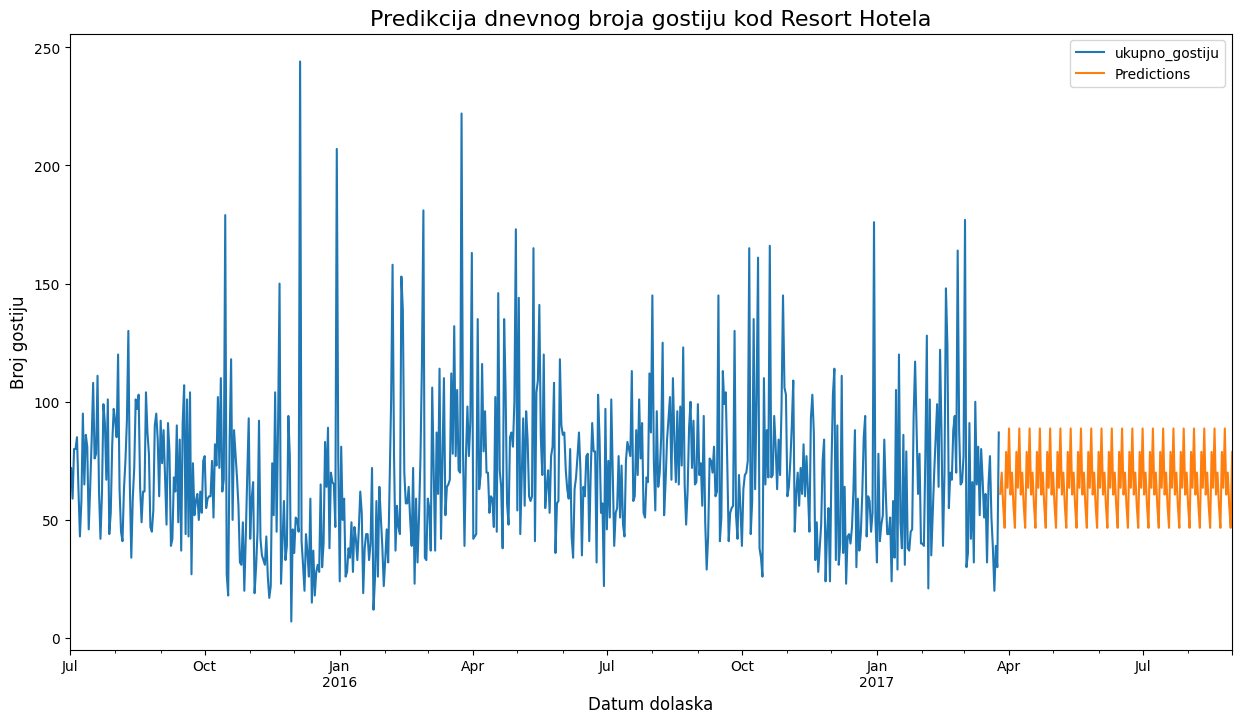

In [143]:
plt.figure(figsize=(15, 8))
trainResortDaily['ukupno_gostiju'].plot(legend=True)
predictionsResortTestDaily.plot(legend=True)
plt.title('Predikcija dnevnog broja gostiju kod Resort Hotela', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [172]:
MeanAbsPercentageErrResortDaily_test = mean_absolute_percentage_error(testResortDaily, predictionsResortTestDaily)
MeanSquaredErrResortDaily_test = mean_squared_error(testResortDaily, predictionsResortTestDaily)
RootMeanSquaredErrResortDaily_test = root_mean_squared_error(testResortDaily, predictionsResortTestDaily)
print('Test MAPE Resort Hotel na dnevnoj razini: %f' % MeanAbsPercentageErrResortDaily_test)
print('Test MSE City Hotel na dnevnoj razini: %f' % MeanSquaredErrCityDaily_test )
print('Test RMSE City Hotel na dnevnoj razini: %f' % RootMeanSquaredErrCityDaily_test )

Test MAPE Resort Hotel na dnevnoj razini: 0.277995
Test MSE City Hotel na dnevnoj razini: 1163.264705
Test RMSE City Hotel na dnevnoj razini: 34.106667


## Predviđanje tjednog broja gostiju 


#### Dickey-Fuller test za podatke o tjednom broju gostiju

In [145]:
ResortWeeklyValues = NumberOfGuestsWeeklyResort.values
result_resort_weekly = adfuller(ResortWeeklyValues)
print('ADF Statistic: %f' % result_resort_weekly [0])
print('p-value: %f' % result_resort_weekly [1])
print('Critical Values:')
for key, value in result_resort_weekly [4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.016325
p-value: 0.033398
Critical Values:
	1%: -3.493
	5%: -2.889
	10%: -2.581


- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost manja od alfe,  možemo odbaciti H0, odnosno serija je stacionarna 

#### Rollling Mean i STD Resort Hotela na tjednoj razini

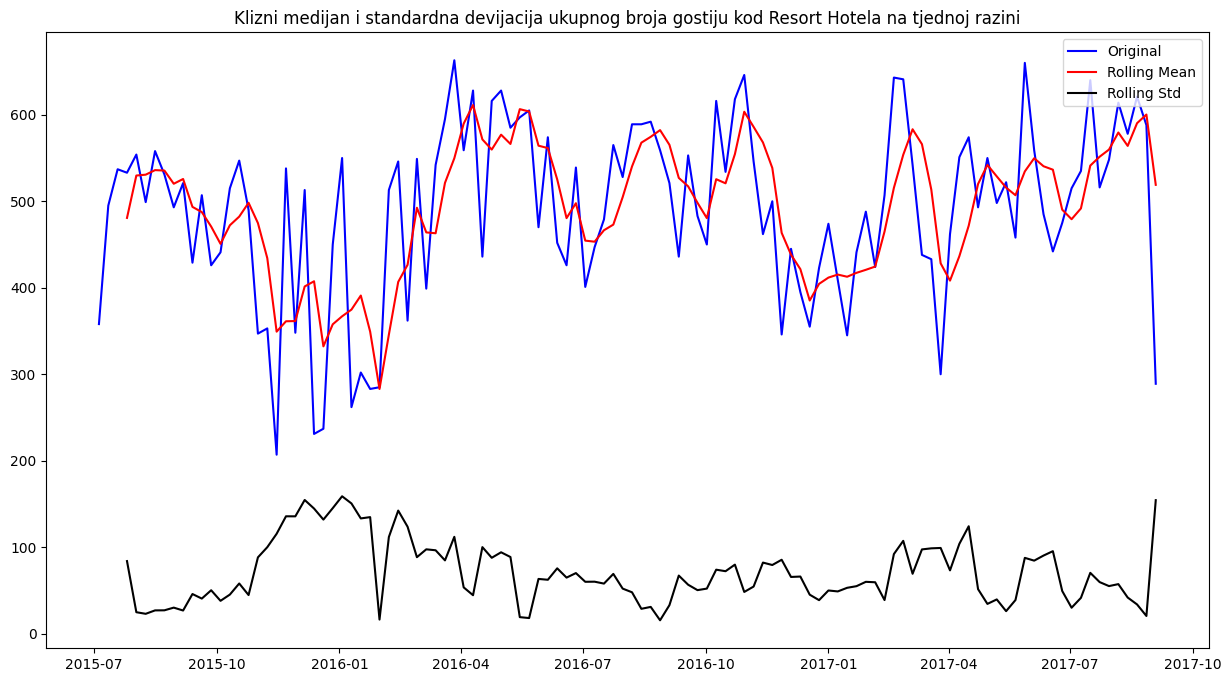

In [146]:
plt.figure(figsize=(15, 8))
rolling_mean_resort_weekly = NumberOfGuestsWeeklyResort.rolling(window=4).mean()
rolling_std_resort_weekly = NumberOfGuestsWeeklyResort.rolling(window=4).std()
plt.plot(NumberOfGuestsWeeklyResort, color='blue', label='Original')
plt.plot(rolling_mean_resort_weekly, color='red', label='Rolling Mean')
plt.plot(rolling_std_resort_weekly, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Klizni medijan i standardna devijacija ukupnog broja gostiju kod Resort Hotela na tjednoj razini')
plt.show()

In [147]:
split_ratio  =  0.8

In [148]:
train_test_split_resort_weekly = int(len(NumberOfGuestsWeeklyResort)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_resort_weekly} podataka, test {len(NumberOfGuestsWeeklyResort)-train_test_split_resort_weekly} podataka")

trainResortWeekly = NumberOfGuestsWeeklyResort[:train_test_split_resort_weekly]
testResortWeekly = NumberOfGuestsWeeklyResort[train_test_split_resort_weekly:]

Split 0.8 na train/test, train ima 91 podataka, test 23 podataka


#### Fit ARIMA modela na podatke na tjednoj bazi

In [150]:
stepwise_fit_resort_weekly = auto_arima(trainResortWeekly['ukupno_gostiju'], 
                          start_p=1, start_q=1,
                          max_p=3, max_q=3, m=54,
                          start_P=0, seasonal=True,
                          d=0, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_resort_weekly.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[54] intercept   : AIC=inf, Time=17.18 sec
 ARIMA(0,0,0)(0,1,0)[54] intercept   : AIC=460.118, Time=0.20 sec
 ARIMA(1,0,0)(1,1,0)[54] intercept   : AIC=inf, Time=14.98 sec
 ARIMA(0,0,1)(0,1,1)[54] intercept   : AIC=inf, Time=9.34 sec
 ARIMA(0,0,0)(0,1,0)[54]             : AIC=465.938, Time=0.21 sec
 ARIMA(0,0,0)(1,1,0)[54] intercept   : AIC=inf, Time=12.03 sec
 ARIMA(0,0,0)(0,1,1)[54] intercept   : AIC=inf, Time=6.37 sec
 ARIMA(0,0,0)(1,1,1)[54] intercept   : AIC=inf, Time=15.00 sec
 ARIMA(1,0,0)(0,1,0)[54] intercept   : AIC=461.940, Time=1.04 sec
 ARIMA(0,0,1)(0,1,0)[54] intercept   : AIC=461.929, Time=0.98 sec
 ARIMA(1,0,1)(0,1,0)[54] intercept   : AIC=463.927, Time=1.02 sec

Best model:  ARIMA(0,0,0)(0,1,0)[54] intercept
Total fit time: 78.401 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   91
Model:             SARIMAX(0, 1, 0, 54)   Log Likelihood                -228.059
Date:                  Thu, 22 Feb 2024   AIC                            460.118
Time:                          21:40:46   BIC                            463.340
Sample:                      07-05-2015   HQIC                           461.254
                           - 03-26-2017                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     55.7838     22.069      2.528      0.011      12.529      99.039
sigma2      1.322e+04   3533.878      3.741      0.000    6295.679    2.01e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 3.39
Prob(Q):                              0.69   Prob(JB):                         0.18
Heteroskedasticity (H):               6.48   Skew:                            -0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(0,0,0)(0,1,0)[54]    je najbolji model te se to preslikava u parametre
- order = (0,0,0)
- seasonal_order = (0,1,0)[54] 


In [151]:
modelResort_weekly = ARIMA(trainResortWeekly['ukupno_gostiju'],
                  order=(0, 0, 0),
                  seasonal_order=(0, 1, 0, 54))

resultResort_weekly= modelResort_weekly.fit()


##### Predikcije modela na test podacima na tjednoj bazi

In [152]:
predictionsResortTestWeekly = resultResort_weekly.predict(train_test_split_resort_weekly, train_test_split_resort_weekly + len(testResortWeekly) - 1, typ='levels').rename("Predictions")


### Predikcija broja gostija na tjednoj razini na testnim podacima


Text(0, 0.5, 'Broj gostiju')

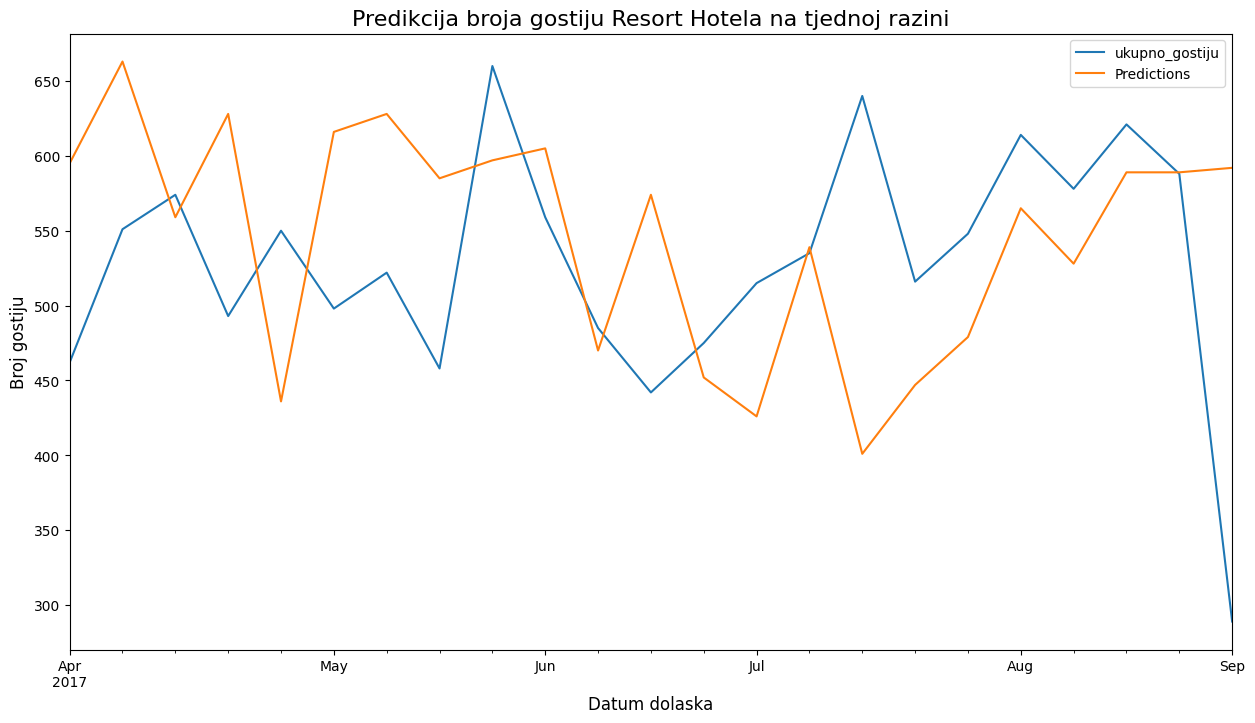

In [153]:
plt.figure(figsize=(15, 8))
testResortWeekly['ukupno_gostiju'].plot(legend=True)
predictionsResortTestWeekly.plot(legend=True)
plt.title('Predikcija broja gostiju Resort Hotela na tjednoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

Text(0, 0.5, 'Broj gostiju')

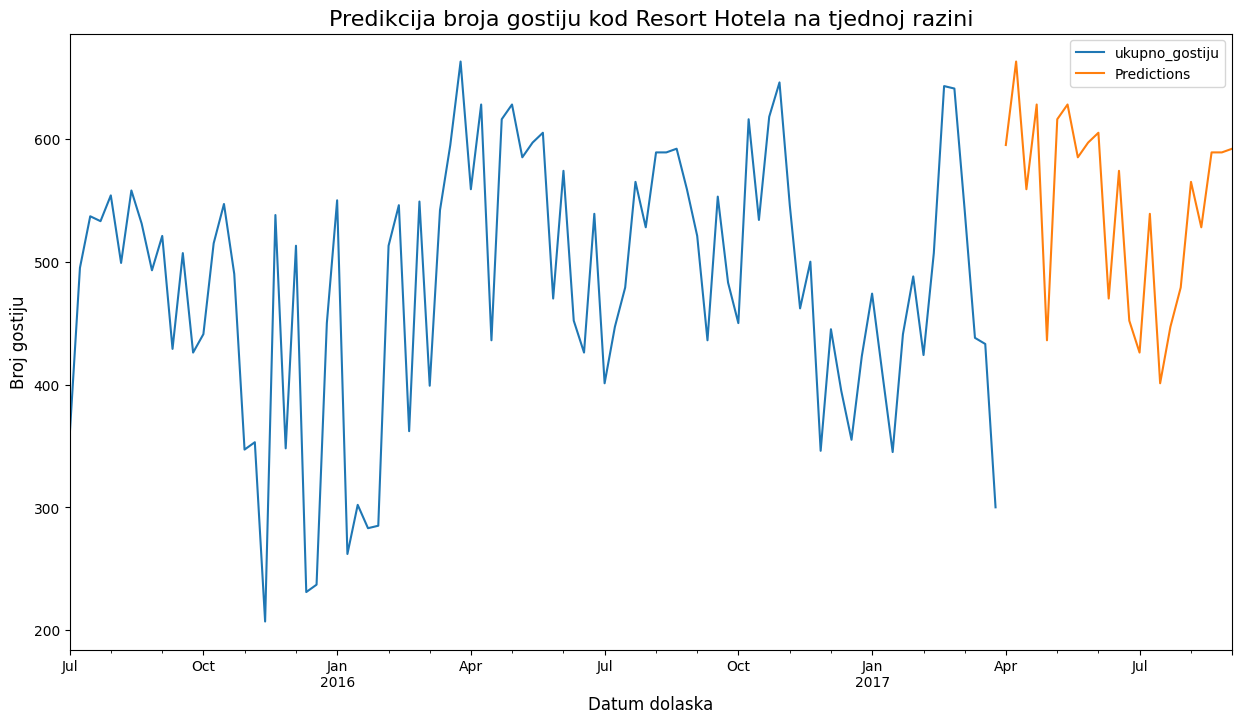

In [154]:
plt.figure(figsize=(15, 8))
trainResortWeekly['ukupno_gostiju'].plot(legend=True)
predictionsResortTestWeekly.plot(legend=True)
plt.title('Predikcija broja gostiju kod Resort Hotela na tjednoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [174]:
MeanAbsPercentageErrResortWeekly_test = mean_absolute_percentage_error(testResortWeekly, predictionsResortTestWeekly)
MeanSquaredErrResortWeekly_test = mean_squared_error(testResortWeekly, predictionsResortTestWeekly)
RootMeanSquaredErrResortWeekly_test = root_mean_squared_error(testResortWeekly, predictionsResortTestWeekly)
print('Test MAPE Resort Hotel na tjednoj razini: %f' % MeanAbsPercentageErrResortWeekly_test)
print('Test MSE City Hotel na tjednoj razini: %f' % MeanSquaredErrCityWeekly_test)
print('Test RMSE City Hotel na tjednoj razini: %f' % RootMeanSquaredErrCityWeekly_test )

Test MAPE Resort Hotel na tjednoj razini: 0.189251
Test MSE City Hotel na tjednoj razini: 245406.918078
Test RMSE City Hotel na tjednoj razini: 495.385626


## Predviđanje mjesečnog broja gostiju 


#### Dickey-Fuller test za podatke o mjesečnom broju gostiju

In [158]:
ResortMonthlyValues = NumberOfGuestsMonthlyResort.values
result_resort_monthly = adfuller(ResortMonthlyValues)
print('ADF Statistic: %f' % result_resort_monthly[0])
print('p-value: %f' % result_resort_monthly[1])
print('Critical Values:')
for key, value in result_resort_monthly[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.277791
p-value: 0.015901
Critical Values:
	1%: -3.724
	5%: -2.986
	10%: -2.633


- Definirajmo razinu značajnosti alfa=0.05
- Kako je p vrijednost manje od alfe, možemo odbaciti H0, odnosno serija je stacionarna 

#### Rollling Mean i STD Resort Hotela na mjesečnoj razini

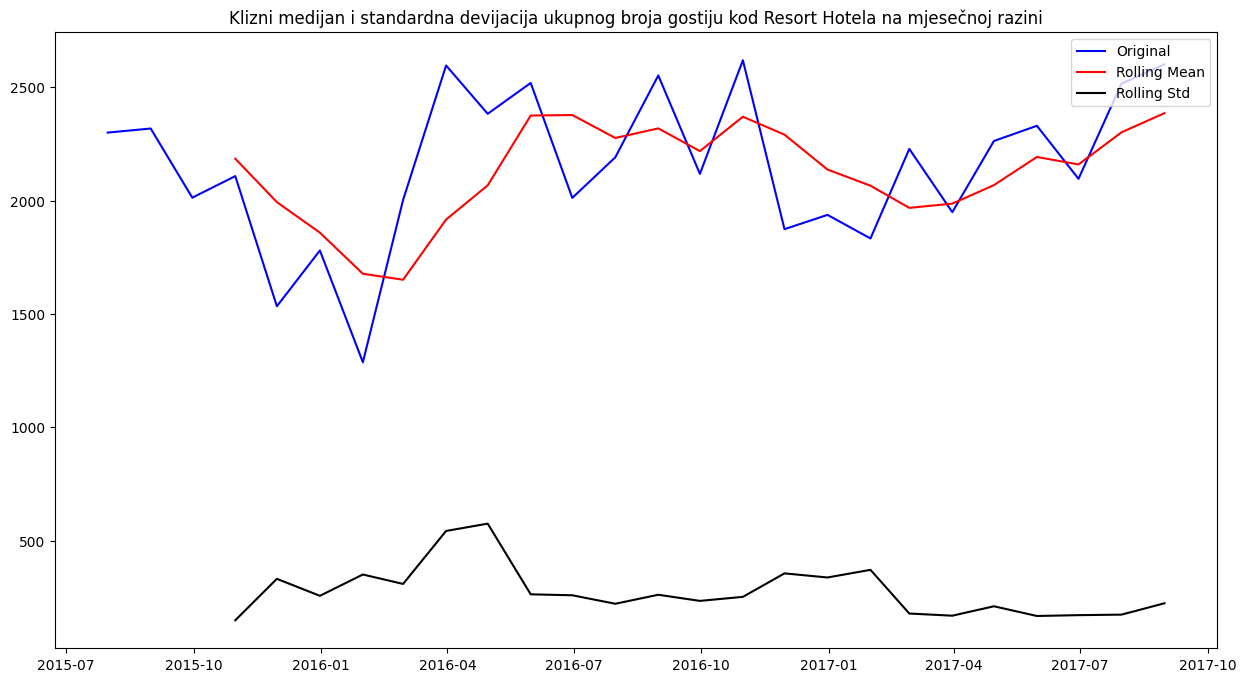

In [159]:
plt.figure(figsize=(15, 8))
rolling_mean_resort_monthly = NumberOfGuestsMonthlyResort.rolling(window=4).mean()
rolling_std_resort_monthly = NumberOfGuestsMonthlyResort.rolling(window=4).std()
plt.plot(NumberOfGuestsMonthlyResort, color='blue', label='Original')
plt.plot(rolling_mean_resort_monthly, color='red', label='Rolling Mean')
plt.plot(rolling_std_resort_monthly, color='black', label='Rolling Std')
plt.legend(loc='upper right')
plt.title('Klizni medijan i standardna devijacija ukupnog broja gostiju kod Resort Hotela na mjesečnoj razini')
plt.show()

In [160]:
split_ratio  =  0.8

In [161]:
train_test_split_resort_monthly = int(len(NumberOfGuestsMonthlyResort)*split_ratio)
print(f"Split {split_ratio} na train/test, train ima {train_test_split_resort_monthly} podataka, test {len(NumberOfGuestsMonthlyResort)-train_test_split_resort_monthly} podataka")

trainResortMonthly = NumberOfGuestsMonthlyResort[:train_test_split_resort_monthly]
testResortMonthly = NumberOfGuestsMonthlyResort[train_test_split_resort_monthly:]

Split 0.8 na train/test, train ima 20 podataka, test 6 podataka


In [162]:
stepwise_fit_resort_monthly = auto_arima(trainResortMonthly['ukupno_gostiju'], 
                          start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=0, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

stepwise_fit_resort_monthly.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=116.638, Time=0.54 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=111.557, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=114.347, Time=0.33 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=117.080, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=113.036, Time=0.07 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=112.960, Time=0.11 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 2.307 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   20
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                 -53.779
Date:                  Thu, 22 Feb 2024   AIC                            111.557
Time:                          21:41:29   BIC                            111.716
Sample:                      07-31-2015   HQIC                           110.486
                           - 02-28-2017                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    251.1250     71.380      3.518      0.000     111.223     391.027
sigma2      4.041e+04   2.56e+04      1.581      0.114   -9672.934    9.05e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                 0.20
Prob(Q):                              0.60   Prob(JB):                         0.91
Heteroskedasticity (H):               0.64   Skew:                            -0.10
Prob(H) (two-sided):                  0.72   Kurtosis:                         2.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Bazirano na izlazu auto_arima metode, koristiti ćemo najbolji model 
- ARIMA(0,0,0)(0,1,0)[12]    je najbolji model te se to preslikava u parametre
- order = (0,0,0)
- seasonal_order = (0,1,0)[12] 


In [163]:
modelResort_monthly = ARIMA(trainResortMonthly['ukupno_gostiju'],
                  order=(0, 0, 0),
                  seasonal_order=(0, 1, 0, 12))

resultResort_monthly= modelResort_monthly.fit()


##### Predikcije modela na test podacima na mjesečnoj bazi

In [164]:
predictionsResortTestMonthly = resultResort_monthly.predict(train_test_split_resort_monthly, train_test_split_resort_monthly + len(testResortMonthly) - 1, typ='levels').rename("Predictions")


### Predikcija broja gostija na mjesečnoj razini na testnim podacima


Text(0, 0.5, 'Broj gostiju')

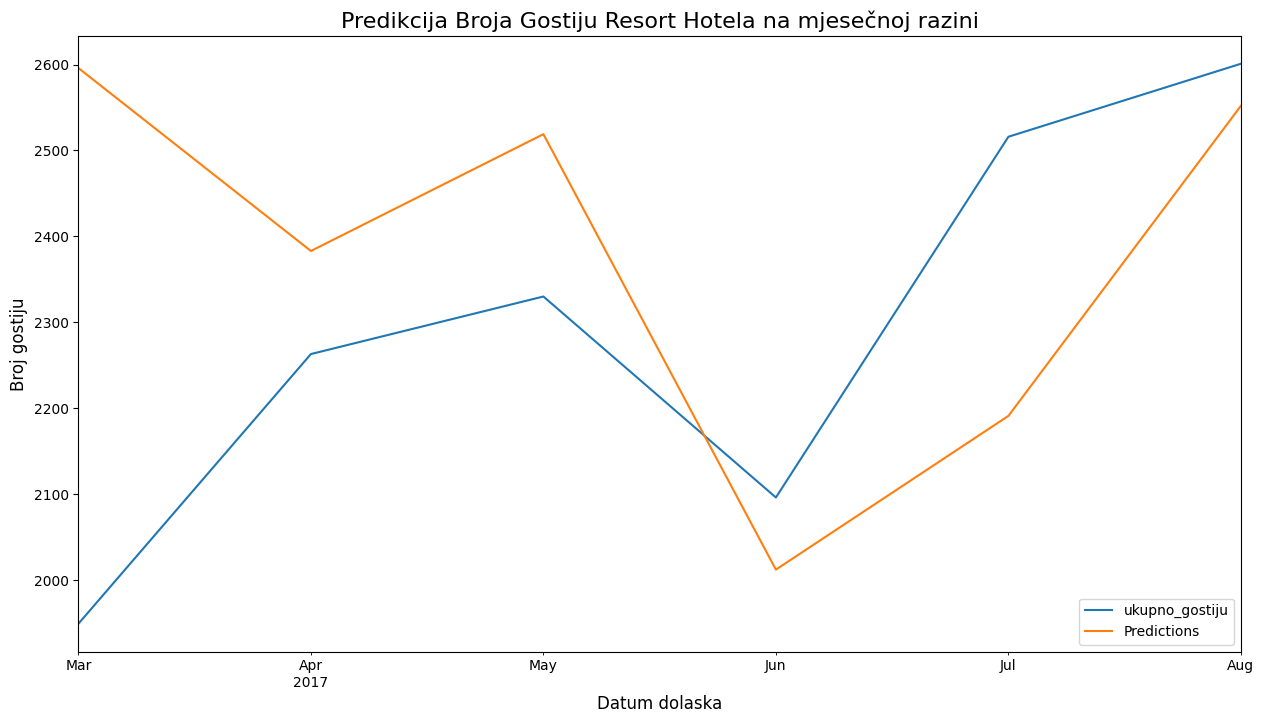

In [165]:
plt.figure(figsize=(15, 8))
testResortMonthly['ukupno_gostiju'].plot(legend=True)
predictionsResortTestMonthly.plot(legend=True)
plt.title('Predikcija Broja Gostiju Resort Hotela na mjesečnoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

Text(0, 0.5, 'Broj gostiju')

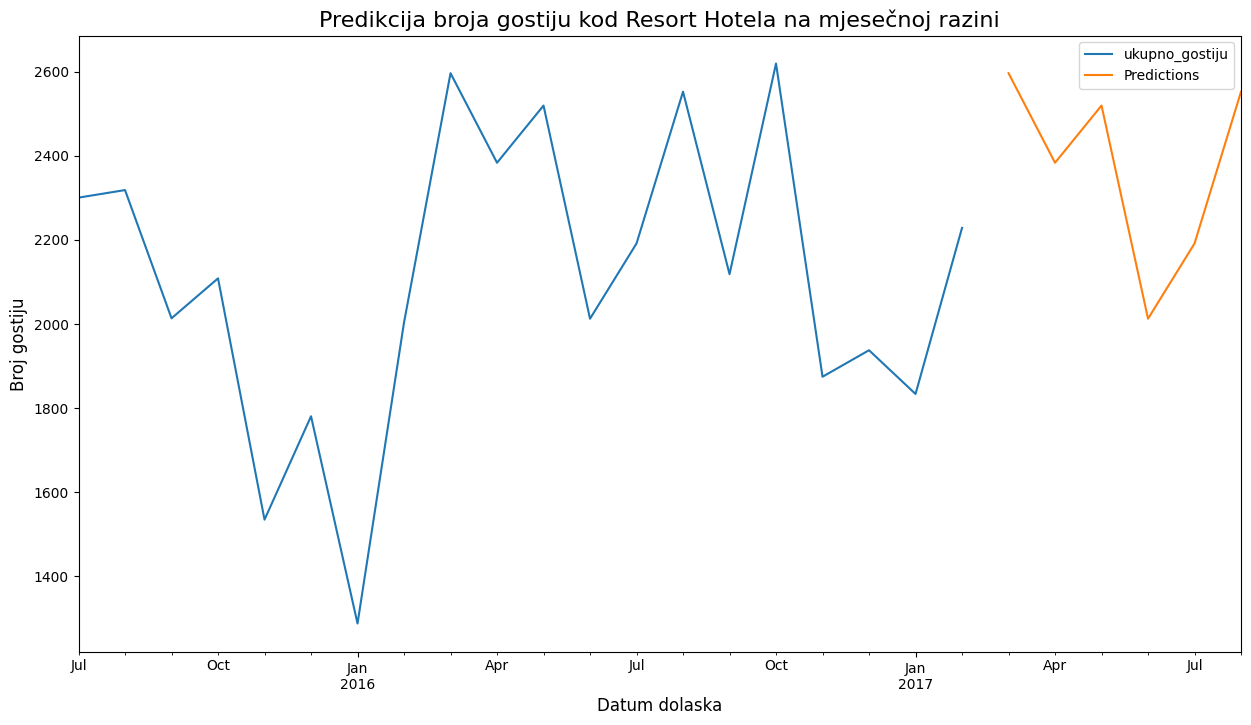

In [166]:
plt.figure(figsize=(15, 8))
trainResortMonthly['ukupno_gostiju'].plot(legend=True)
predictionsResortTestMonthly.plot(legend=True)
plt.title('Predikcija broja gostiju kod Resort Hotela na mjesečnoj razini', fontsize=16)
plt.xlabel('Datum dolaska', fontsize=12)
plt.ylabel('Broj gostiju', fontsize=12)

In [167]:
MeanAbsPercentageErrResortMonthly_test = mean_absolute_percentage_error(testResortMonthly, predictionsResortTestMonthly)
MeanSquaredErrResortMonthly_test = mean_squared_error(testResortMonthly, predictionsResortTestMonthly)
RootMeanSquaredErrResortMonthly_test = root_mean_squared_error(testResortMonthly, predictionsResortTestMonthly)
print('Test MAPE Resort Hotel na mjesečnoj razini: %f' % MeanAbsPercentageErrResortMonthly_test )
print('Test MSE City Hotel na mjesečnoj razini: %f' % MeanSquaredErrResortMonthly_test)
print('Test RMSE City Hotel na mjesečnoj  razini: %f' % RootMeanSquaredErrResortMonthly_test)

Test MAPE Resort Hotel na mjesečnoj razini: 0.109033
Test MSE City Hotel na mjesečnoj razini: 97302.000000
Test RMSE City Hotel na mjesečnoj  razini: 311.932685


In [168]:
MeanAbsPercentageErrResortMonthly_test = mean_absolute_percentage_error(testResortMonthly, predictionsResortTestMonthly)
print('Test MAPE Resort Hotel na mjesečnoj razini: %f' % MeanAbsPercentageErrResortMonthly_test)

Test MAPE Resort Hotel na mjesečnoj razini: 0.109033


## Pregled svih rezultata 

In [175]:
errors_data = {
    'Hotel': ['City', 'City', 'City', 'Resort', 'Resort', 'Resort'],
    'Time Range': ['Daily', 'Weekly', 'Monthly', 'Daily', 'Weekly', 'Monthly'],
    'MeanAbsPercentageError/%': [
        MeanAbsPercentageErrCityDaily_test,
        MeanAbsPercentageErrCityWeekly_test,
        MeanAbsPercentageErrCityMonthly_test,
        MeanAbsPercentageErrResortDaily_test,
        MeanAbsPercentageErrResortWeekly_test,
        MeanAbsPercentageErrResortMonthly_test
    ],
    'MeanSquaredError/%': [
        MeanSquaredErrCityDaily_test,
        MeanSquaredErrCityWeekly_test,
        MeanSquaredErrCityMonthly_test,
        MeanSquaredErrResortDaily_test,
        MeanSquaredErrResortWeekly_test ,
        MeanSquaredErrResortMonthly_test
    ],
    'RootMeanSquaredError/%': [
        RootMeanSquaredErrCityDaily_test,
        RootMeanSquaredErrCityWeekly_test,
        RootMeanSquaredErrCityMonthly_test,
        RootMeanSquaredErrResortDaily_test,
        RootMeanSquaredErrResortWeekly_test ,
        RootMeanSquaredErrResortMonthly_test
    ],
    
}

errors_df = pd.DataFrame(errors_data)
errors_df = errors_df.style.format({'MeanAbsPercentageError': "{:.2f}"})

In [176]:
errors_df

,Hotel,Time Range,MeanAbsPercentageError/%,MeanSquaredError/%,RootMeanSquaredError/%
0,City,Daily,0.269380,1163.264705,34.106667
1,City,Weekly,0.610819,245406.918078,495.385626
2,City,Monthly,0.583682,4447887.766771,2109.001604
3,Resort,Daily,0.277995,768.783166,27.726939
4,Resort,Weekly,0.189251,13023.739130,114.121598
5,Resort,Monthly,0.109033,97302.000000,311.932685
